In [0]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import numpy as np

Using TensorFlow backend.


In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 2
        noise = np.random.normal(0, 1, (20, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.721956, acc.: 31.25%] [G loss: 0.509457]


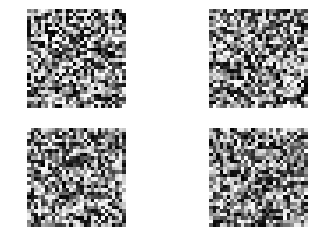

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


200 [D loss: 0.508869, acc.: 73.44%] [G loss: 3.594146]


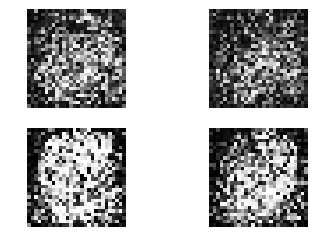

400 [D loss: 0.630345, acc.: 59.38%] [G loss: 0.952536]


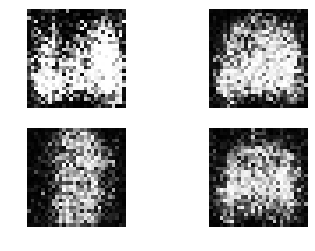

600 [D loss: 0.676882, acc.: 60.94%] [G loss: 0.972981]


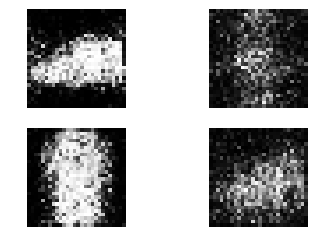

800 [D loss: 0.605621, acc.: 60.94%] [G loss: 0.900063]


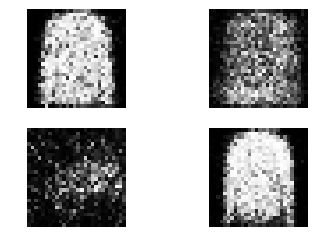

1000 [D loss: 0.689976, acc.: 59.38%] [G loss: 0.815933]


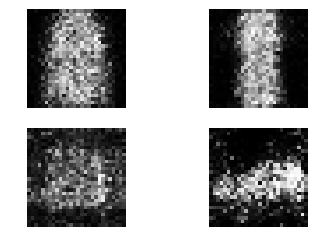

1200 [D loss: 0.604612, acc.: 60.94%] [G loss: 0.823872]


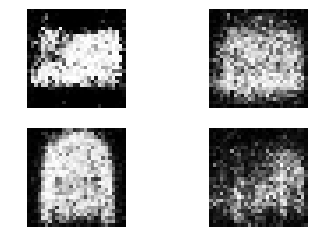

1400 [D loss: 0.638765, acc.: 59.38%] [G loss: 0.815392]


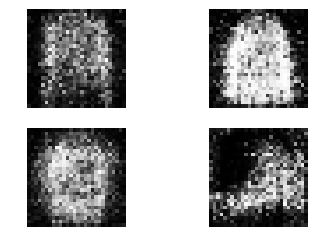

1600 [D loss: 0.643248, acc.: 65.62%] [G loss: 0.856196]


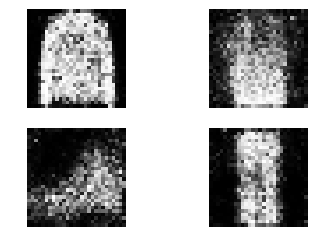

1800 [D loss: 0.582843, acc.: 76.56%] [G loss: 0.864307]


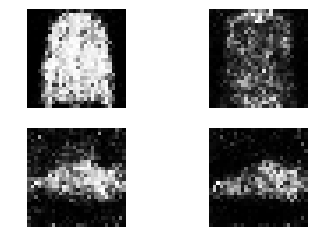

2000 [D loss: 0.648815, acc.: 59.38%] [G loss: 0.931636]


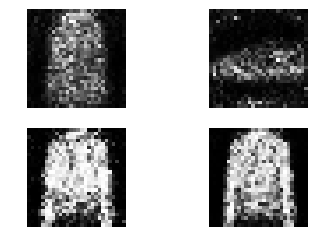

2200 [D loss: 0.716481, acc.: 48.44%] [G loss: 0.879494]


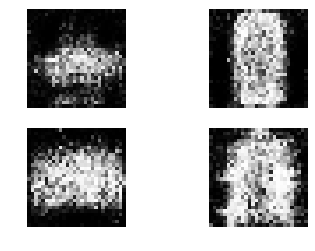

2400 [D loss: 0.644418, acc.: 57.81%] [G loss: 0.800922]


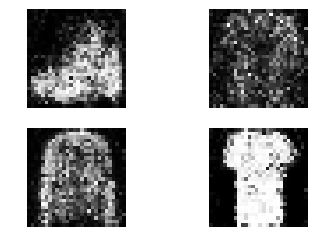

2600 [D loss: 0.644220, acc.: 59.38%] [G loss: 0.869509]


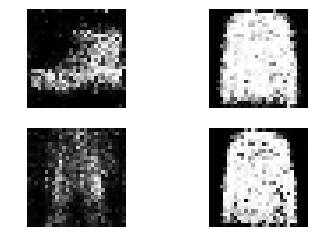

2800 [D loss: 0.686121, acc.: 59.38%] [G loss: 0.916103]


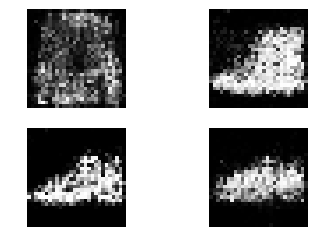

3000 [D loss: 0.675892, acc.: 56.25%] [G loss: 0.865733]


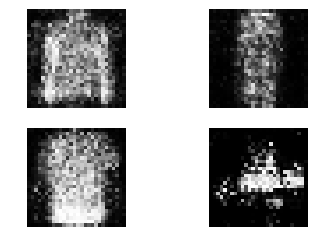

3200 [D loss: 0.631881, acc.: 64.06%] [G loss: 0.874610]


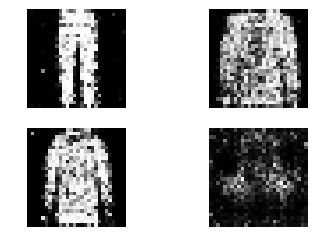

3400 [D loss: 0.659165, acc.: 65.62%] [G loss: 0.888639]


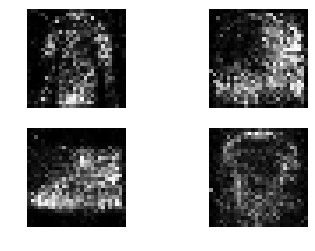

3600 [D loss: 0.566243, acc.: 73.44%] [G loss: 0.826210]


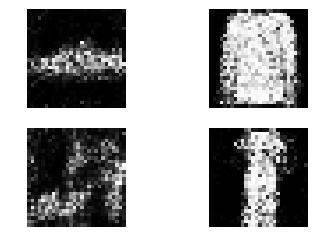

3800 [D loss: 0.615145, acc.: 71.88%] [G loss: 0.991446]


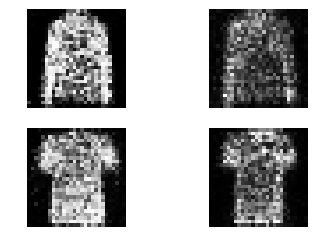

4000 [D loss: 0.616238, acc.: 67.19%] [G loss: 0.956281]


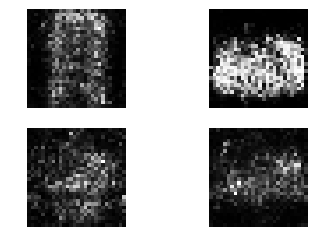

4200 [D loss: 0.651862, acc.: 67.19%] [G loss: 0.883458]


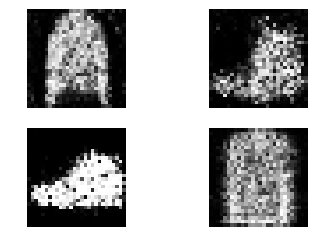

4400 [D loss: 0.638507, acc.: 67.19%] [G loss: 0.866860]


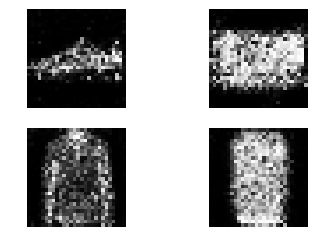

4600 [D loss: 0.666489, acc.: 60.94%] [G loss: 0.834855]


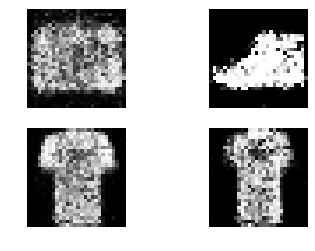

4800 [D loss: 0.658229, acc.: 59.38%] [G loss: 0.869037]


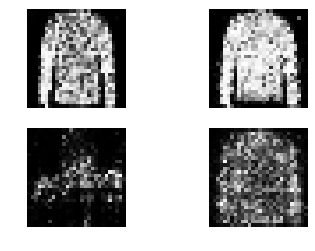

5000 [D loss: 0.612999, acc.: 65.62%] [G loss: 0.955545]


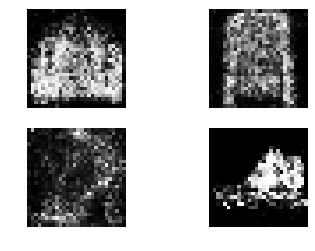

5200 [D loss: 0.720977, acc.: 50.00%] [G loss: 0.823795]


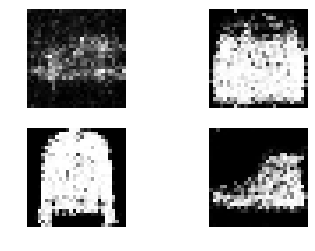

5400 [D loss: 0.673237, acc.: 56.25%] [G loss: 0.911726]


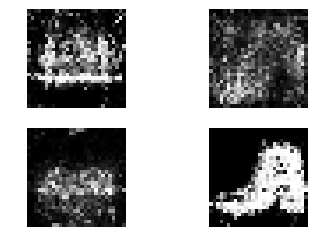

5600 [D loss: 0.660631, acc.: 59.38%] [G loss: 0.840321]


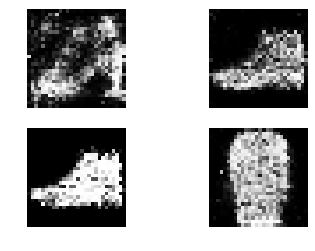

5800 [D loss: 0.642657, acc.: 65.62%] [G loss: 0.892127]


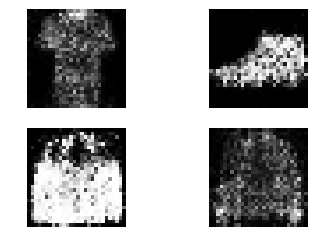

6000 [D loss: 0.643666, acc.: 53.12%] [G loss: 0.827908]


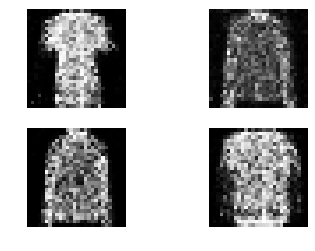

6200 [D loss: 0.669448, acc.: 57.81%] [G loss: 0.811010]


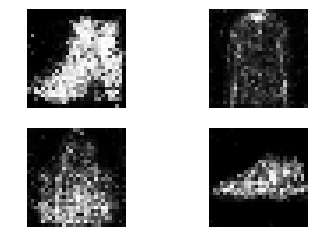

6400 [D loss: 0.664705, acc.: 62.50%] [G loss: 0.825327]


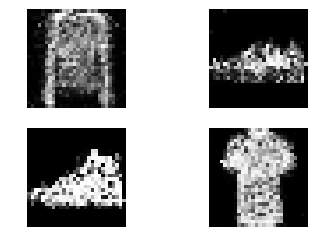

6600 [D loss: 0.641682, acc.: 59.38%] [G loss: 0.816203]


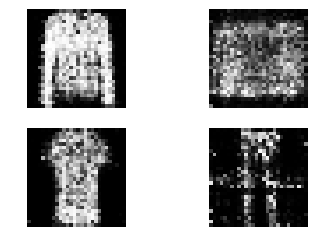

6800 [D loss: 0.662823, acc.: 67.19%] [G loss: 0.887362]


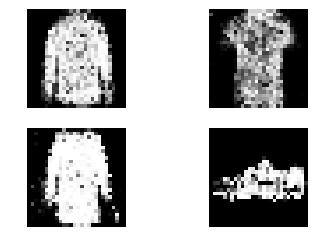

7000 [D loss: 0.594271, acc.: 76.56%] [G loss: 0.899413]


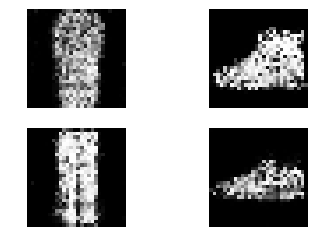

7200 [D loss: 0.691226, acc.: 54.69%] [G loss: 0.924762]


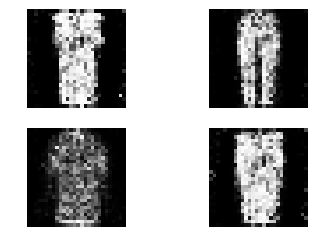

7400 [D loss: 0.655045, acc.: 62.50%] [G loss: 0.931646]


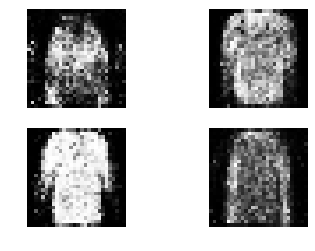

7600 [D loss: 0.683204, acc.: 57.81%] [G loss: 0.775063]


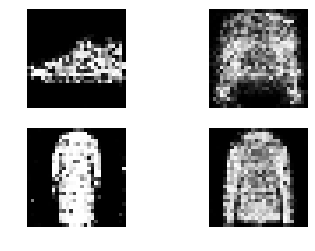

7800 [D loss: 0.684756, acc.: 62.50%] [G loss: 0.942665]


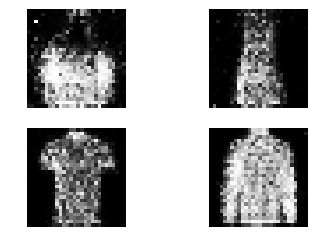

8000 [D loss: 0.694540, acc.: 48.44%] [G loss: 1.017111]


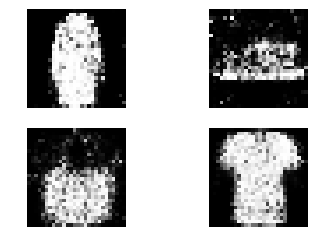

8200 [D loss: 0.689045, acc.: 59.38%] [G loss: 0.810068]


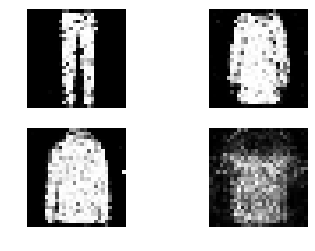

8400 [D loss: 0.682483, acc.: 59.38%] [G loss: 0.900139]


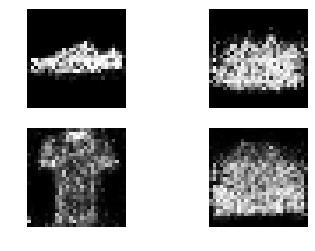

8600 [D loss: 0.673247, acc.: 59.38%] [G loss: 0.917544]


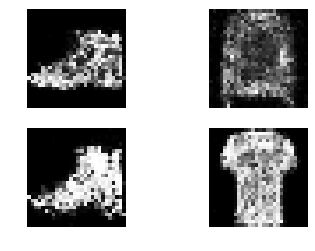

8800 [D loss: 0.662165, acc.: 60.94%] [G loss: 0.961912]


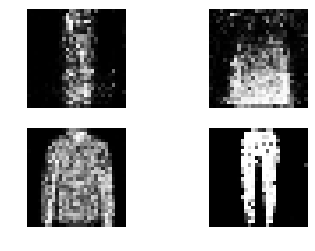

9000 [D loss: 0.648203, acc.: 59.38%] [G loss: 0.860657]


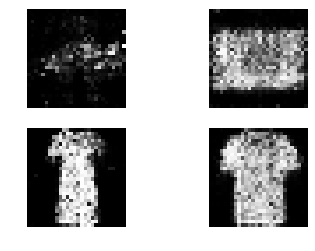

9200 [D loss: 0.665248, acc.: 56.25%] [G loss: 0.822598]


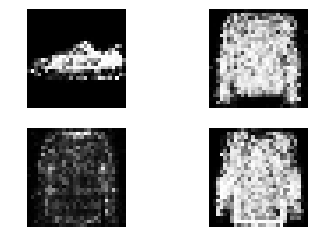

9400 [D loss: 0.712628, acc.: 53.12%] [G loss: 0.920238]


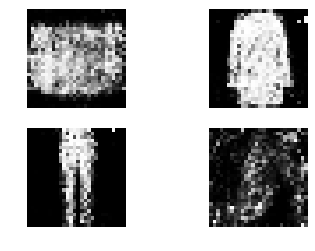

9600 [D loss: 0.690650, acc.: 56.25%] [G loss: 0.917501]


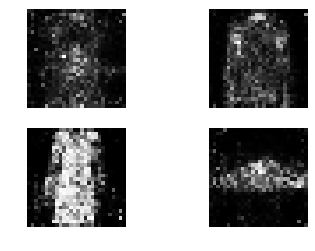

9800 [D loss: 0.638386, acc.: 62.50%] [G loss: 0.869166]


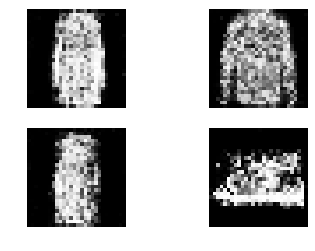

10000 [D loss: 0.649432, acc.: 65.62%] [G loss: 0.907323]


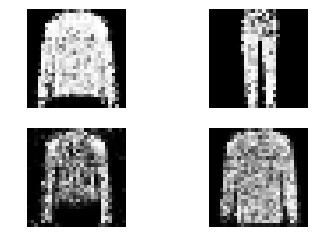

10200 [D loss: 0.662395, acc.: 59.38%] [G loss: 0.957532]


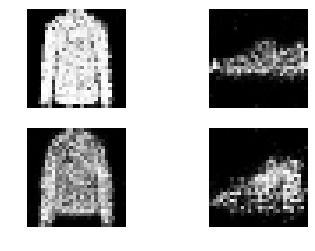

10400 [D loss: 0.607754, acc.: 64.06%] [G loss: 0.834529]


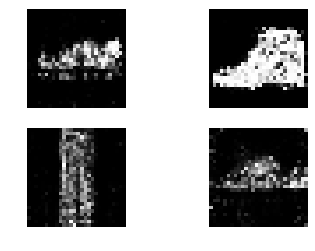

10600 [D loss: 0.660096, acc.: 54.69%] [G loss: 0.915776]


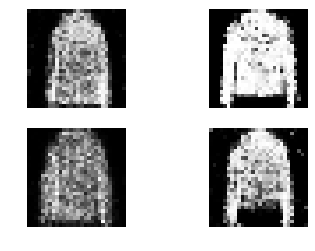

10800 [D loss: 0.670901, acc.: 67.19%] [G loss: 0.879191]


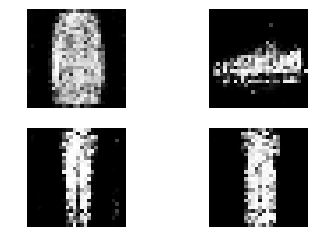

11000 [D loss: 0.685520, acc.: 43.75%] [G loss: 0.876549]


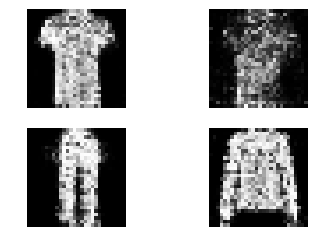

11200 [D loss: 0.672311, acc.: 59.38%] [G loss: 0.894871]


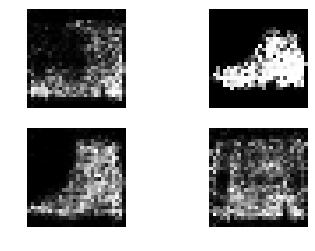

11400 [D loss: 0.668341, acc.: 59.38%] [G loss: 0.803563]


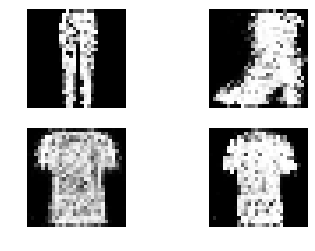

11600 [D loss: 0.743351, acc.: 50.00%] [G loss: 0.824407]


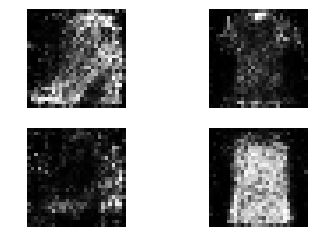

11800 [D loss: 0.658036, acc.: 62.50%] [G loss: 0.937959]


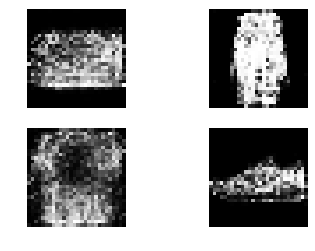

12000 [D loss: 0.699155, acc.: 51.56%] [G loss: 0.890626]


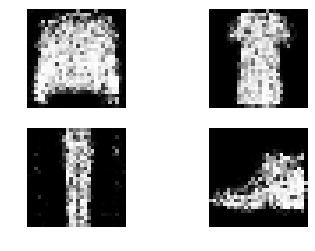

12200 [D loss: 0.641800, acc.: 60.94%] [G loss: 0.965397]


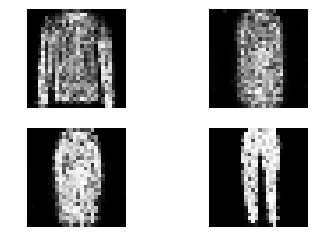

12400 [D loss: 0.662356, acc.: 59.38%] [G loss: 0.821317]


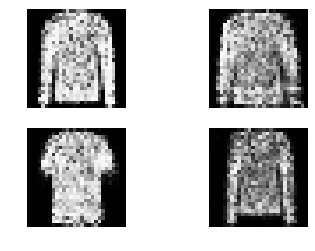

12600 [D loss: 0.689967, acc.: 60.94%] [G loss: 0.889770]


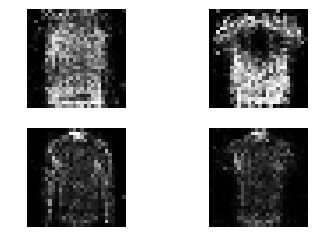

12800 [D loss: 0.712763, acc.: 51.56%] [G loss: 0.899624]


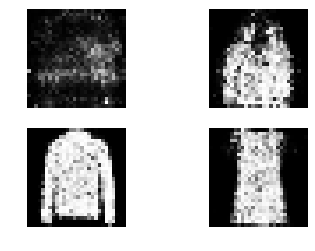

13000 [D loss: 0.633881, acc.: 60.94%] [G loss: 0.896661]


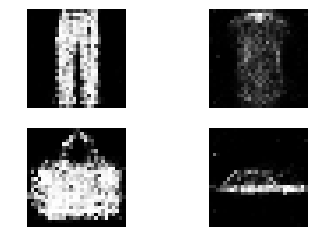

13200 [D loss: 0.664788, acc.: 56.25%] [G loss: 0.936155]


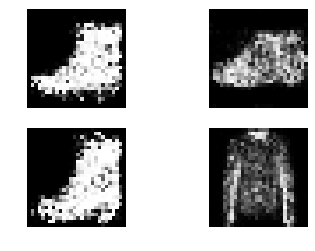

13400 [D loss: 0.651290, acc.: 56.25%] [G loss: 0.945262]


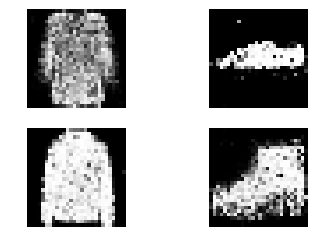

13600 [D loss: 0.640239, acc.: 60.94%] [G loss: 0.820752]


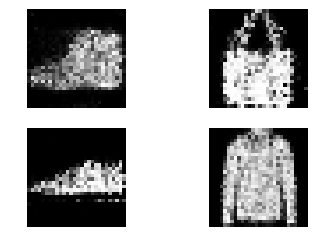

13800 [D loss: 0.620688, acc.: 67.19%] [G loss: 0.787415]


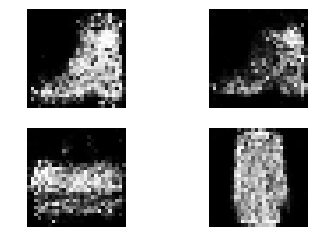

14000 [D loss: 0.666142, acc.: 57.81%] [G loss: 0.846316]


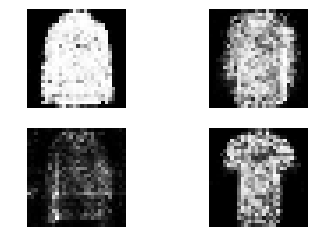

14200 [D loss: 0.670421, acc.: 62.50%] [G loss: 0.917444]


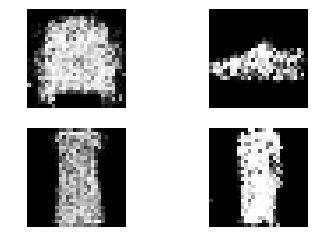

14400 [D loss: 0.662739, acc.: 56.25%] [G loss: 0.848988]


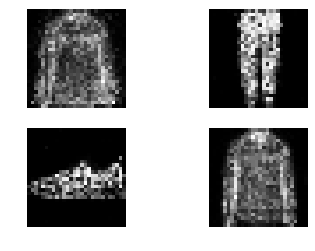

14600 [D loss: 0.643206, acc.: 65.62%] [G loss: 0.809406]


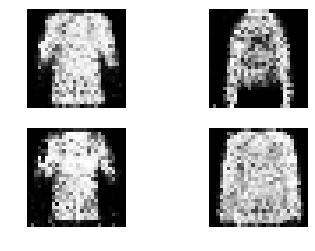

14800 [D loss: 0.628819, acc.: 62.50%] [G loss: 1.036986]


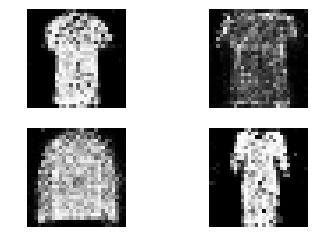

15000 [D loss: 0.614055, acc.: 67.19%] [G loss: 0.937526]


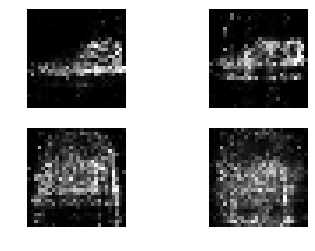

15200 [D loss: 0.663491, acc.: 64.06%] [G loss: 0.895387]


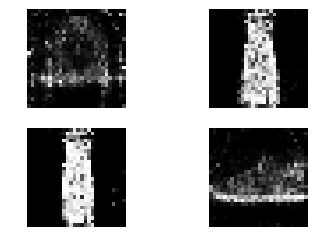

15400 [D loss: 0.651110, acc.: 59.38%] [G loss: 0.894024]


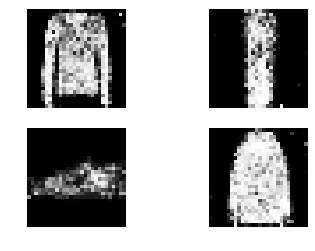

15600 [D loss: 0.671851, acc.: 54.69%] [G loss: 0.869355]


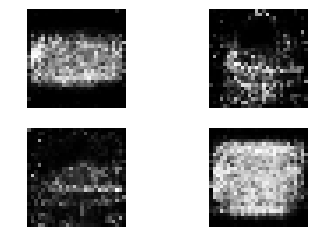

15800 [D loss: 0.685930, acc.: 51.56%] [G loss: 0.886214]


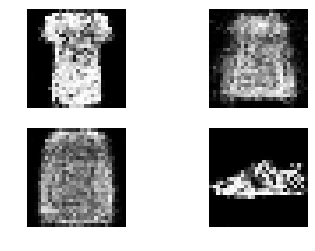

16000 [D loss: 0.671036, acc.: 56.25%] [G loss: 0.877748]


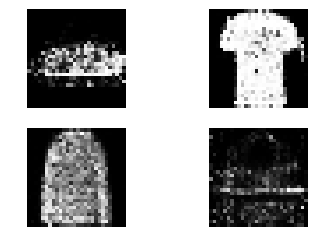

16200 [D loss: 0.653385, acc.: 64.06%] [G loss: 0.904614]


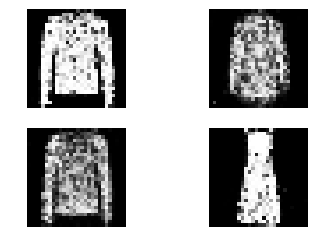

16400 [D loss: 0.622101, acc.: 67.19%] [G loss: 0.960999]


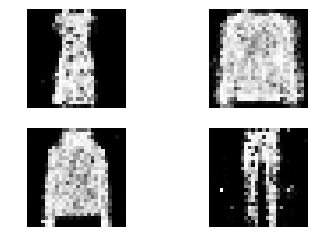

16600 [D loss: 0.626604, acc.: 67.19%] [G loss: 0.993207]


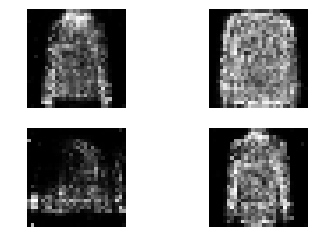

16800 [D loss: 0.690828, acc.: 56.25%] [G loss: 0.908138]


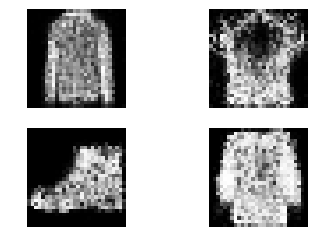

17000 [D loss: 0.564426, acc.: 70.31%] [G loss: 0.937902]


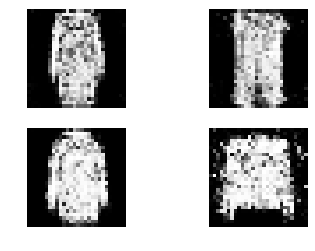

17200 [D loss: 0.701408, acc.: 56.25%] [G loss: 0.906697]


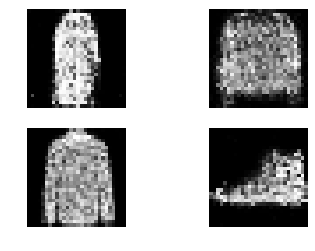

17400 [D loss: 0.550990, acc.: 82.81%] [G loss: 0.979978]


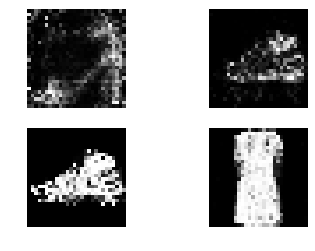

17600 [D loss: 0.603898, acc.: 73.44%] [G loss: 0.913560]


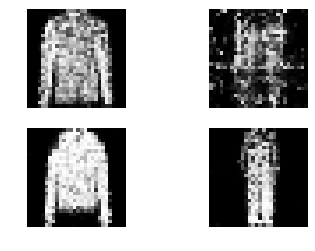

17800 [D loss: 0.678151, acc.: 51.56%] [G loss: 0.940614]


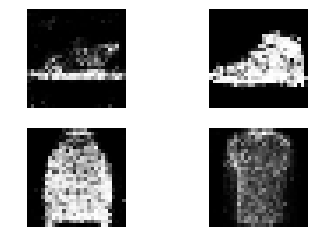

18000 [D loss: 0.642852, acc.: 59.38%] [G loss: 0.878995]


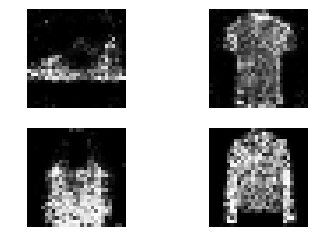

18200 [D loss: 0.627361, acc.: 73.44%] [G loss: 0.918064]


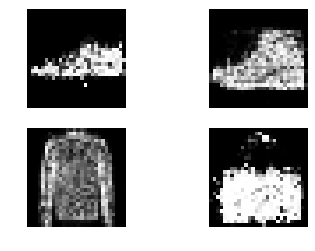

18400 [D loss: 0.640822, acc.: 59.38%] [G loss: 0.883463]


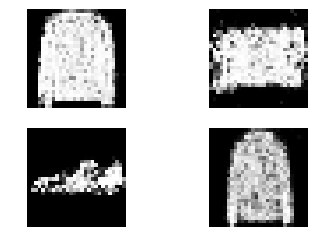

18600 [D loss: 0.670226, acc.: 53.12%] [G loss: 0.888740]


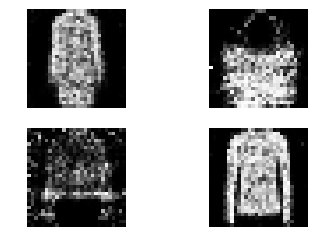

18800 [D loss: 0.610936, acc.: 68.75%] [G loss: 0.899195]


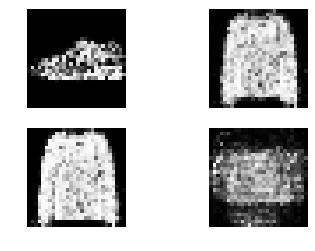

19000 [D loss: 0.707144, acc.: 45.31%] [G loss: 1.026067]


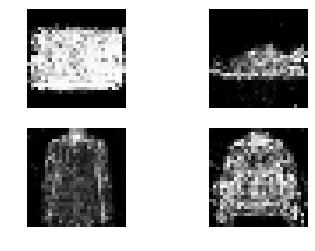

19200 [D loss: 0.659246, acc.: 64.06%] [G loss: 0.884731]


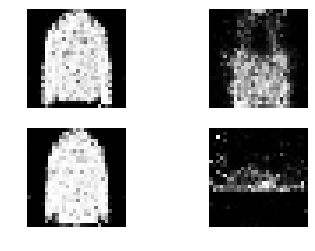

19400 [D loss: 0.687845, acc.: 51.56%] [G loss: 0.898904]


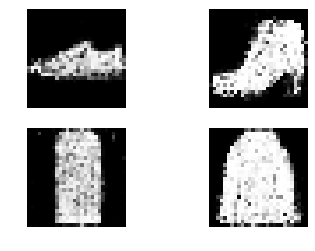

19600 [D loss: 0.686585, acc.: 51.56%] [G loss: 0.931326]


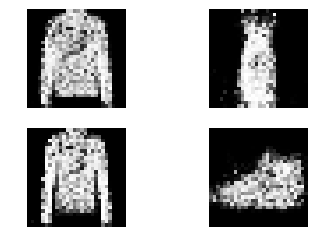

19800 [D loss: 0.626133, acc.: 67.19%] [G loss: 0.870535]


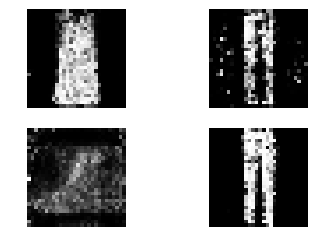

20000 [D loss: 0.722276, acc.: 57.81%] [G loss: 0.894397]


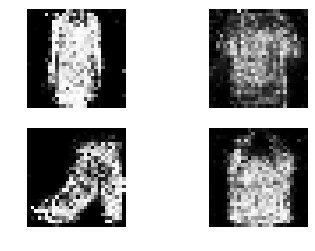

20200 [D loss: 0.629069, acc.: 65.62%] [G loss: 0.850758]


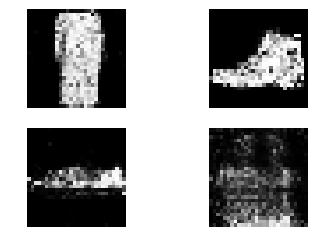

20400 [D loss: 0.703412, acc.: 57.81%] [G loss: 0.938322]


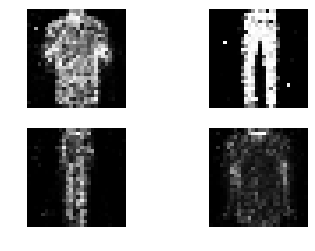

20600 [D loss: 0.642125, acc.: 67.19%] [G loss: 0.940599]


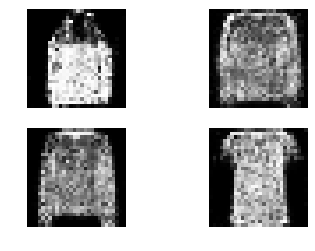

20800 [D loss: 0.650508, acc.: 60.94%] [G loss: 0.988266]


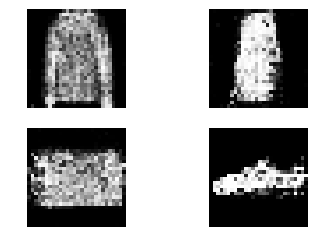

21000 [D loss: 0.581543, acc.: 78.12%] [G loss: 0.971332]


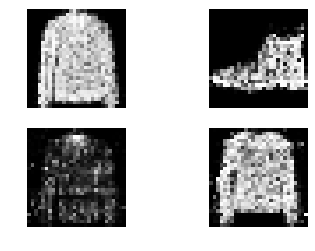

21200 [D loss: 0.648731, acc.: 62.50%] [G loss: 1.025018]


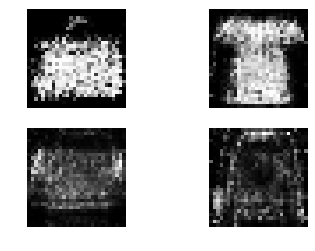

21400 [D loss: 0.597890, acc.: 73.44%] [G loss: 0.877203]


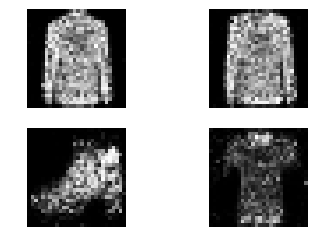

21600 [D loss: 0.677947, acc.: 59.38%] [G loss: 0.906978]


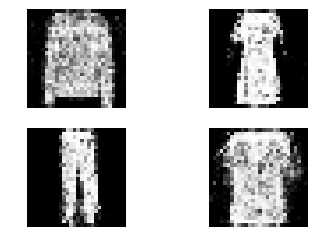

21800 [D loss: 0.625923, acc.: 65.62%] [G loss: 1.002850]


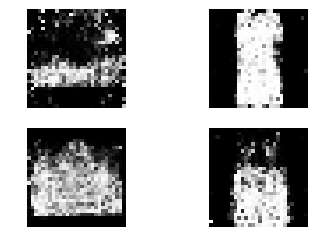

22000 [D loss: 0.614390, acc.: 68.75%] [G loss: 0.921976]


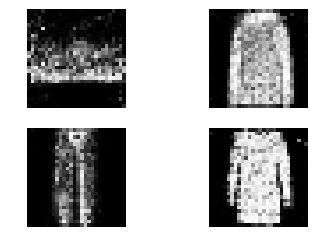

22200 [D loss: 0.690231, acc.: 54.69%] [G loss: 0.876760]


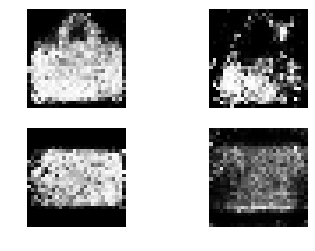

22400 [D loss: 0.650820, acc.: 57.81%] [G loss: 0.925920]


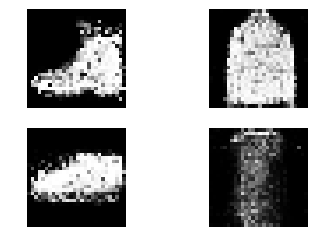

22600 [D loss: 0.668438, acc.: 64.06%] [G loss: 0.911121]


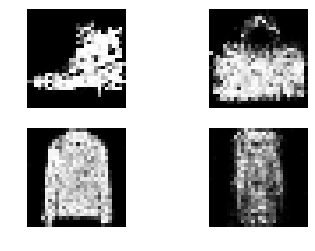

22800 [D loss: 0.725055, acc.: 54.69%] [G loss: 0.891287]


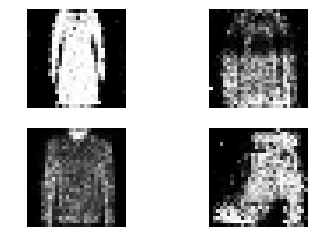

23000 [D loss: 0.642928, acc.: 62.50%] [G loss: 0.898251]


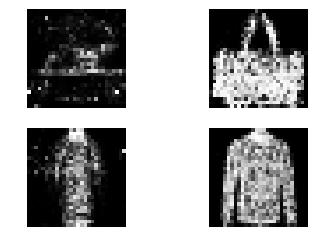

23200 [D loss: 0.645180, acc.: 62.50%] [G loss: 0.957599]


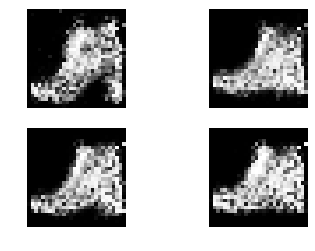

23400 [D loss: 0.618469, acc.: 64.06%] [G loss: 0.955144]


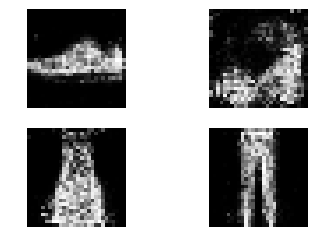

23600 [D loss: 0.674092, acc.: 62.50%] [G loss: 1.049719]


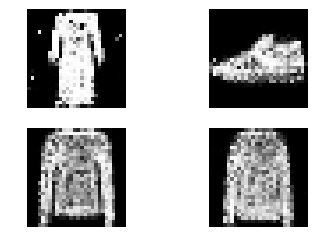

23800 [D loss: 0.711815, acc.: 57.81%] [G loss: 0.877113]


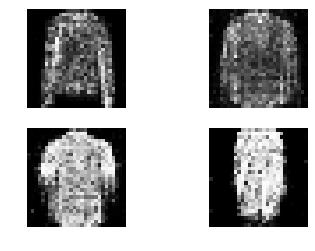

24000 [D loss: 0.549981, acc.: 84.38%] [G loss: 0.960017]


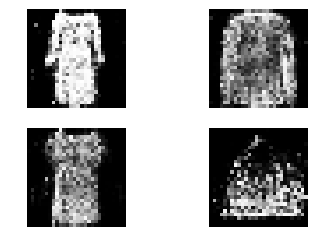

24200 [D loss: 0.662186, acc.: 60.94%] [G loss: 0.912444]


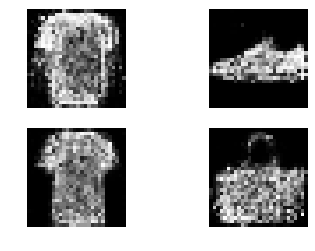

24400 [D loss: 0.631852, acc.: 59.38%] [G loss: 0.987924]


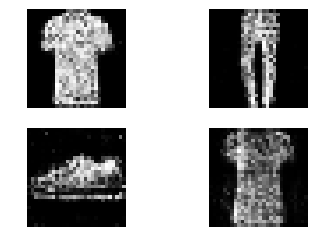

24600 [D loss: 0.581747, acc.: 70.31%] [G loss: 1.011997]


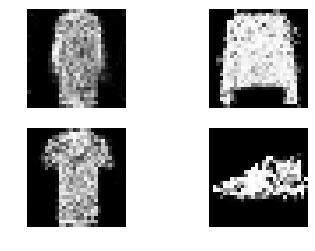

24800 [D loss: 0.718879, acc.: 48.44%] [G loss: 0.914468]


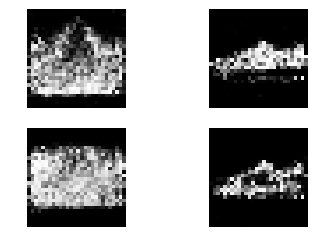

25000 [D loss: 0.559134, acc.: 73.44%] [G loss: 0.962831]


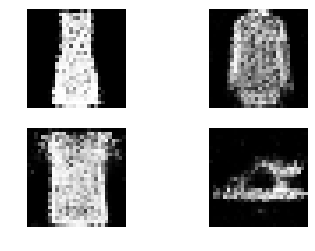

25200 [D loss: 0.691910, acc.: 59.38%] [G loss: 0.935619]


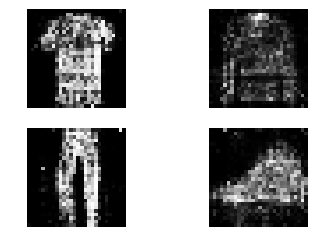

25400 [D loss: 0.634985, acc.: 54.69%] [G loss: 0.917537]


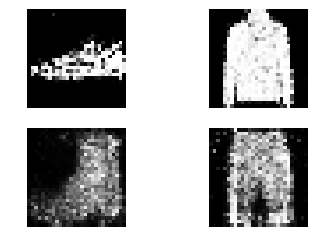

25600 [D loss: 0.630293, acc.: 64.06%] [G loss: 0.923958]


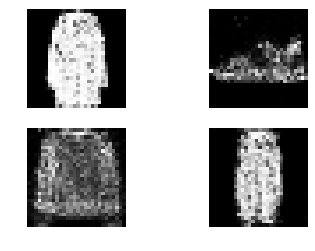

25800 [D loss: 0.644363, acc.: 59.38%] [G loss: 1.001959]


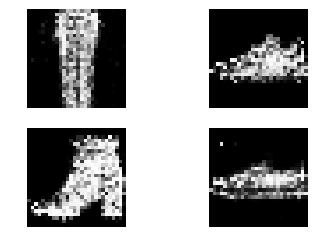

26000 [D loss: 0.672685, acc.: 59.38%] [G loss: 0.890406]


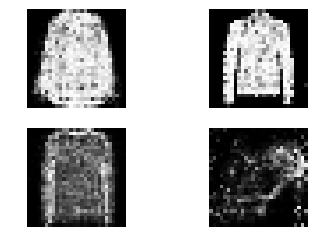

26200 [D loss: 0.646289, acc.: 60.94%] [G loss: 1.036989]


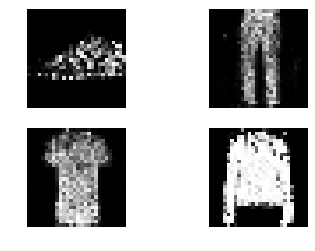

26400 [D loss: 0.699722, acc.: 57.81%] [G loss: 0.854394]


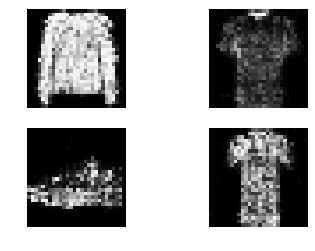

26600 [D loss: 0.542687, acc.: 78.12%] [G loss: 1.042306]


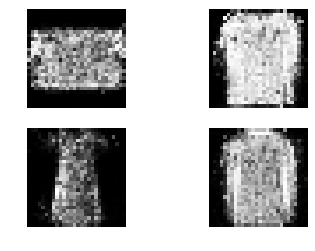

26800 [D loss: 0.633343, acc.: 67.19%] [G loss: 0.983184]


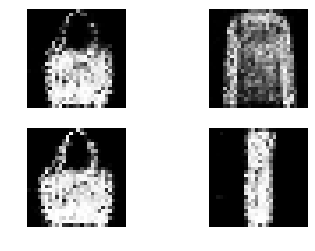

27000 [D loss: 0.631586, acc.: 67.19%] [G loss: 0.936723]


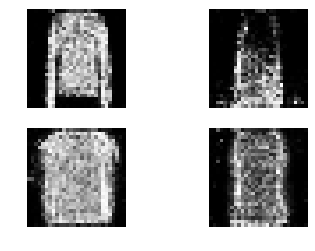

27200 [D loss: 0.558885, acc.: 75.00%] [G loss: 0.963206]


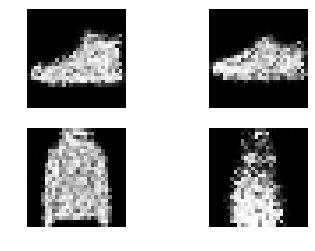

27400 [D loss: 0.705257, acc.: 56.25%] [G loss: 0.944598]


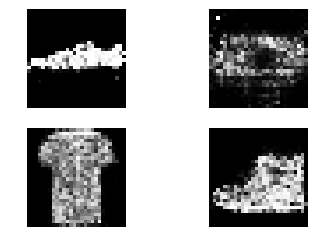

27600 [D loss: 0.618421, acc.: 71.88%] [G loss: 0.917625]


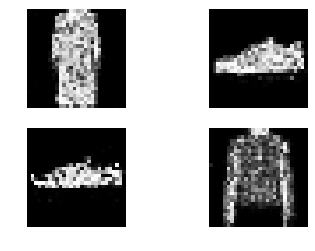

27800 [D loss: 0.624971, acc.: 64.06%] [G loss: 0.955894]


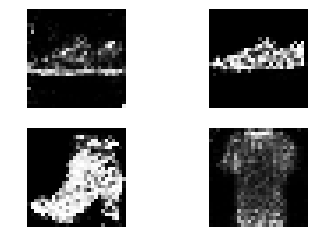

28000 [D loss: 0.638531, acc.: 62.50%] [G loss: 0.985664]


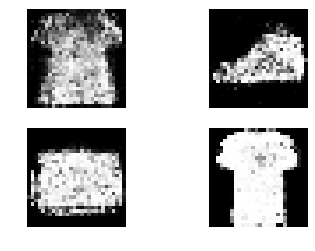

28200 [D loss: 0.547944, acc.: 71.88%] [G loss: 1.056620]


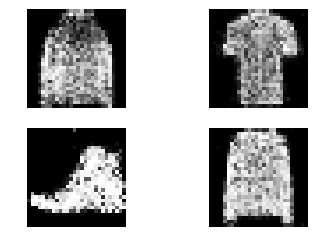

28400 [D loss: 0.625617, acc.: 59.38%] [G loss: 1.024709]


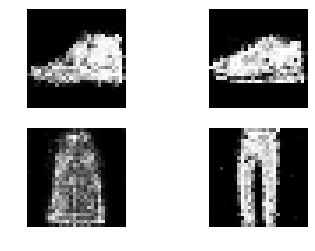

28600 [D loss: 0.612586, acc.: 64.06%] [G loss: 1.119286]


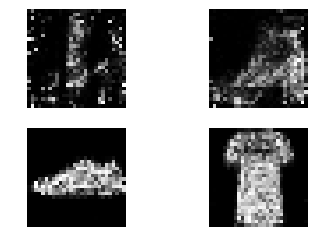

28800 [D loss: 0.601691, acc.: 70.31%] [G loss: 0.989486]


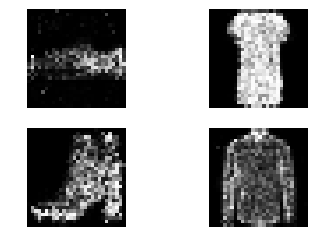

29000 [D loss: 0.609747, acc.: 64.06%] [G loss: 0.951965]


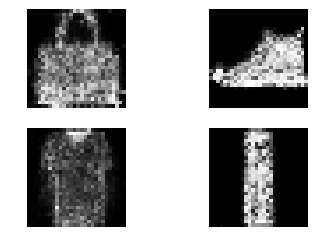

29200 [D loss: 0.634612, acc.: 62.50%] [G loss: 0.875015]


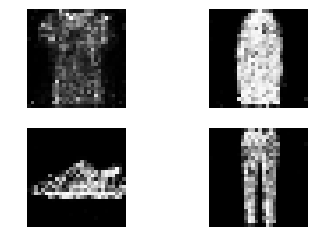

29400 [D loss: 0.628384, acc.: 65.62%] [G loss: 1.008919]


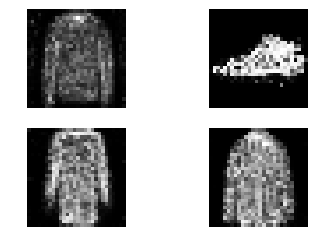

29600 [D loss: 0.573388, acc.: 75.00%] [G loss: 0.998326]


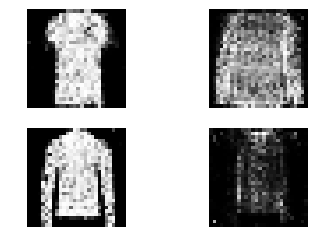

29800 [D loss: 0.602568, acc.: 62.50%] [G loss: 0.984546]


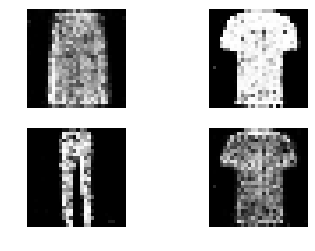

30000 [D loss: 0.593074, acc.: 68.75%] [G loss: 0.963768]


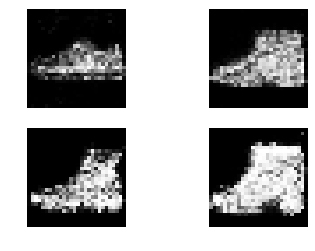

30200 [D loss: 0.645918, acc.: 64.06%] [G loss: 1.029666]


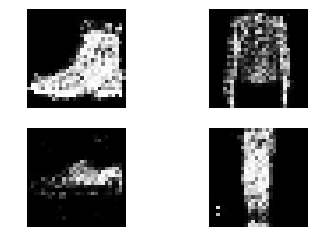

30400 [D loss: 0.670744, acc.: 57.81%] [G loss: 1.019376]


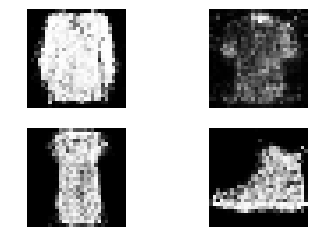

30600 [D loss: 0.610189, acc.: 68.75%] [G loss: 0.974686]


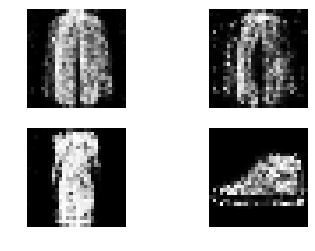

30800 [D loss: 0.671341, acc.: 60.94%] [G loss: 0.948718]


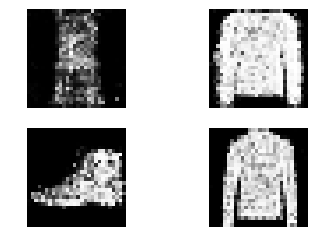

31000 [D loss: 0.640519, acc.: 65.62%] [G loss: 0.866340]


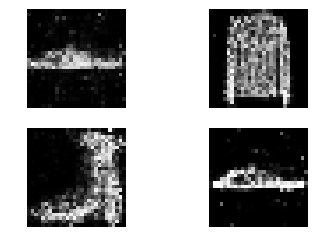

31200 [D loss: 0.692101, acc.: 56.25%] [G loss: 0.996606]


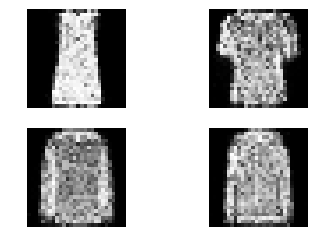

31400 [D loss: 0.607423, acc.: 67.19%] [G loss: 0.986779]


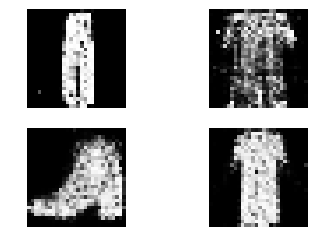

31600 [D loss: 0.609476, acc.: 64.06%] [G loss: 0.973681]


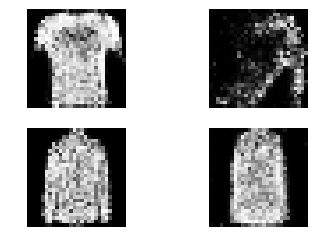

31800 [D loss: 0.631661, acc.: 65.62%] [G loss: 0.984175]


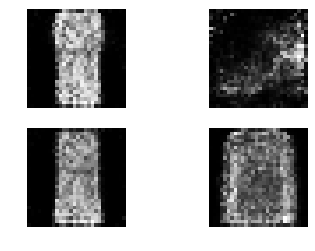

32000 [D loss: 0.643638, acc.: 65.62%] [G loss: 1.067406]


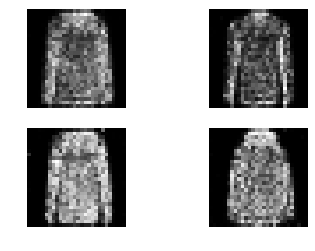

32200 [D loss: 0.702125, acc.: 56.25%] [G loss: 1.009610]


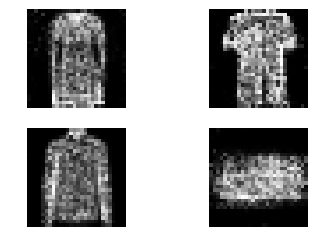

32400 [D loss: 0.715021, acc.: 53.12%] [G loss: 1.053206]


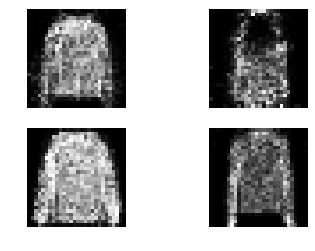

32600 [D loss: 0.651068, acc.: 62.50%] [G loss: 1.042686]


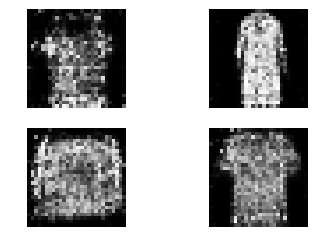

32800 [D loss: 0.637727, acc.: 60.94%] [G loss: 1.014646]


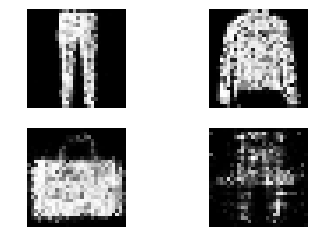

33000 [D loss: 0.585606, acc.: 70.31%] [G loss: 1.032167]


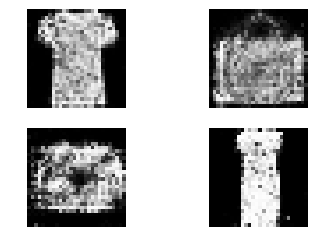

33200 [D loss: 0.685407, acc.: 57.81%] [G loss: 1.077760]


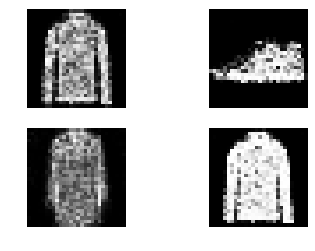

33400 [D loss: 0.668549, acc.: 56.25%] [G loss: 0.969264]


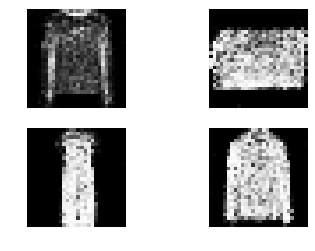

33600 [D loss: 0.610423, acc.: 64.06%] [G loss: 0.927321]


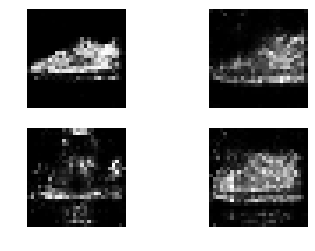

33800 [D loss: 0.649058, acc.: 53.12%] [G loss: 0.967787]


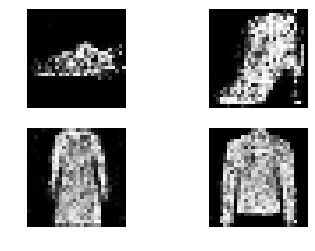

34000 [D loss: 0.594350, acc.: 68.75%] [G loss: 1.002473]


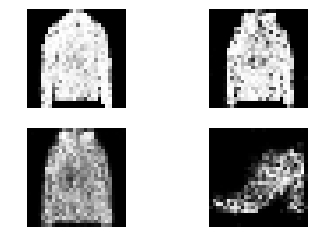

34200 [D loss: 0.604751, acc.: 60.94%] [G loss: 0.864550]


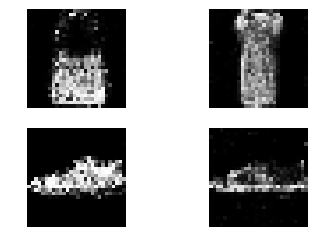

34400 [D loss: 0.660893, acc.: 57.81%] [G loss: 0.961555]


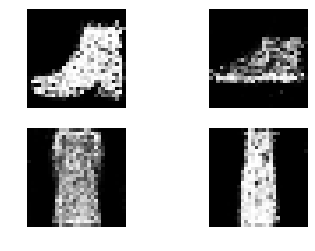

34600 [D loss: 0.638040, acc.: 62.50%] [G loss: 0.944238]


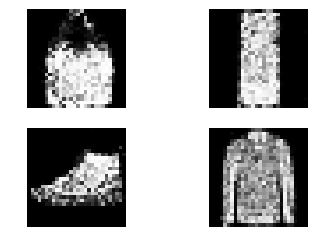

34800 [D loss: 0.589601, acc.: 67.19%] [G loss: 0.923810]


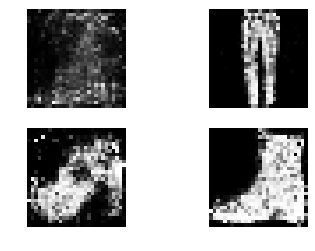

35000 [D loss: 0.629287, acc.: 64.06%] [G loss: 0.921721]


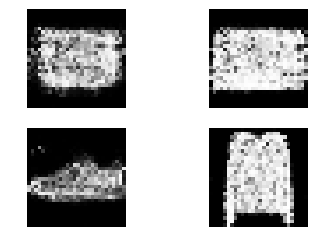

35200 [D loss: 0.706240, acc.: 60.94%] [G loss: 1.009629]


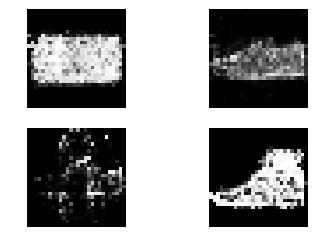

35400 [D loss: 0.612541, acc.: 62.50%] [G loss: 0.973405]


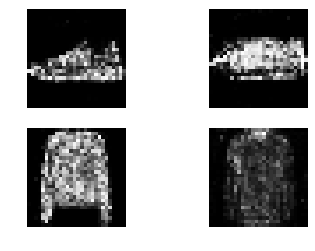

35600 [D loss: 0.657395, acc.: 64.06%] [G loss: 0.965147]


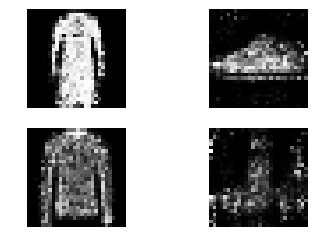

35800 [D loss: 0.609409, acc.: 64.06%] [G loss: 1.058610]


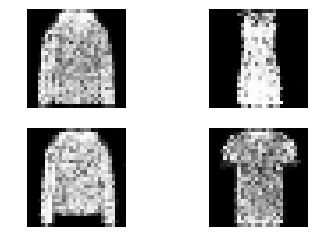

36000 [D loss: 0.593913, acc.: 70.31%] [G loss: 1.057656]


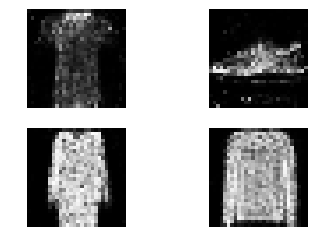

36200 [D loss: 0.632633, acc.: 62.50%] [G loss: 1.021950]


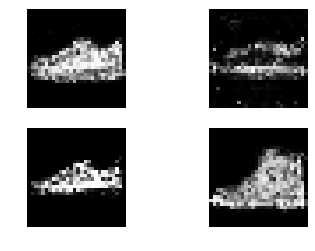

36400 [D loss: 0.562038, acc.: 71.88%] [G loss: 1.020840]


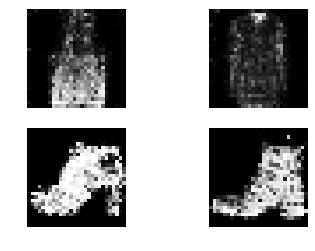

36600 [D loss: 0.598280, acc.: 62.50%] [G loss: 1.111837]


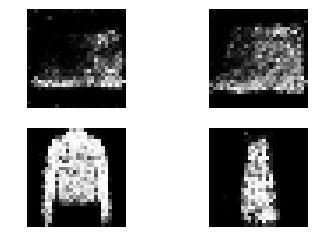

36800 [D loss: 0.527182, acc.: 76.56%] [G loss: 0.938934]


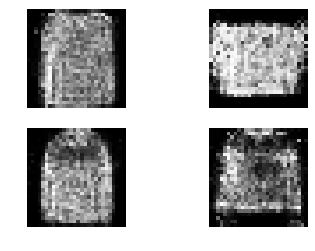

37000 [D loss: 0.552484, acc.: 71.88%] [G loss: 1.086165]


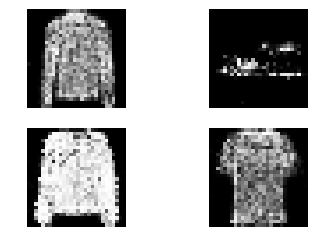

37200 [D loss: 0.548907, acc.: 75.00%] [G loss: 0.864380]


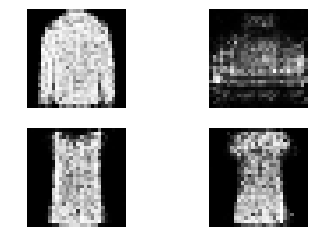

37400 [D loss: 0.613730, acc.: 62.50%] [G loss: 1.114653]


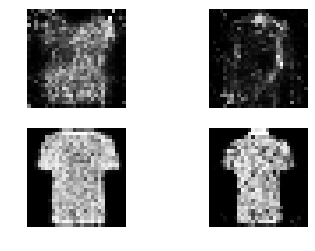

37600 [D loss: 0.642261, acc.: 64.06%] [G loss: 0.998215]


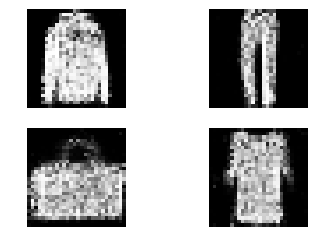

37800 [D loss: 0.593845, acc.: 71.88%] [G loss: 1.157207]


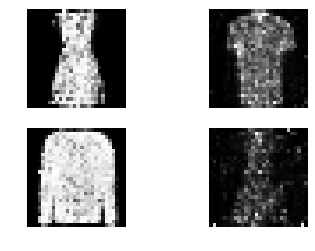

38000 [D loss: 0.661057, acc.: 64.06%] [G loss: 1.090409]


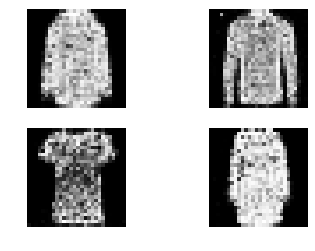

38200 [D loss: 0.621789, acc.: 57.81%] [G loss: 1.091113]


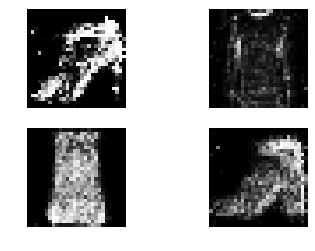

38400 [D loss: 0.605366, acc.: 62.50%] [G loss: 1.047403]


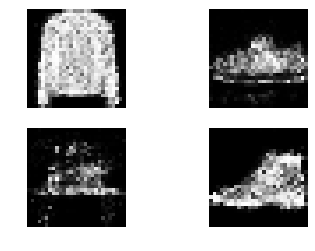

38600 [D loss: 0.620157, acc.: 65.62%] [G loss: 0.923505]


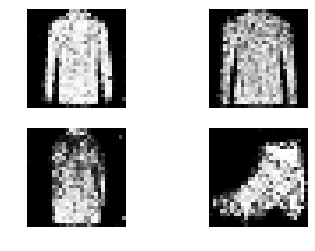

38800 [D loss: 0.688235, acc.: 62.50%] [G loss: 1.193998]


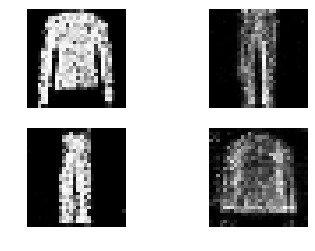

39000 [D loss: 0.596968, acc.: 64.06%] [G loss: 0.946029]


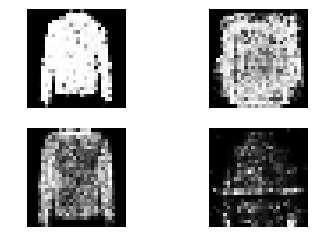

39200 [D loss: 0.669711, acc.: 57.81%] [G loss: 0.963677]


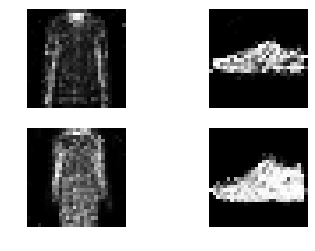

39400 [D loss: 0.559288, acc.: 76.56%] [G loss: 0.961084]


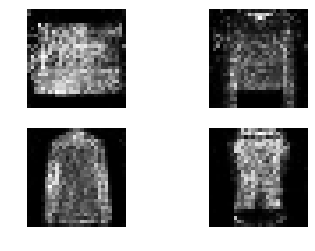

39600 [D loss: 0.646645, acc.: 56.25%] [G loss: 0.935654]


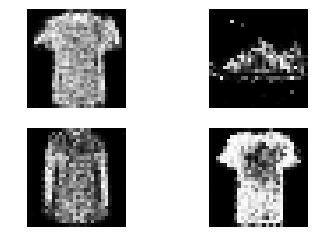

39800 [D loss: 0.757452, acc.: 53.12%] [G loss: 0.943292]


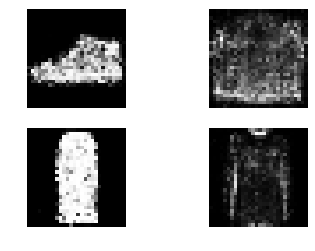

40000 [D loss: 0.608002, acc.: 64.06%] [G loss: 1.048847]


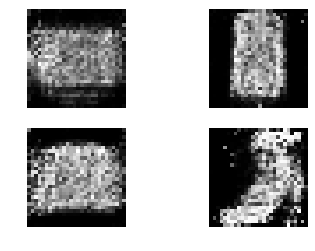

40200 [D loss: 0.619510, acc.: 65.62%] [G loss: 1.165542]


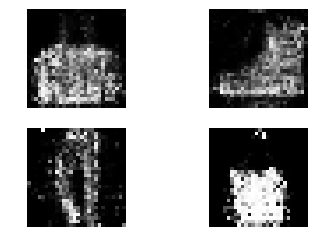

40400 [D loss: 0.554411, acc.: 73.44%] [G loss: 1.025680]


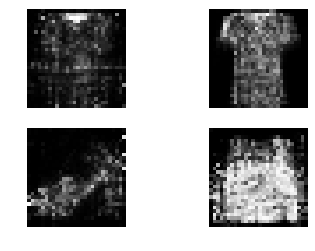

40600 [D loss: 0.684214, acc.: 62.50%] [G loss: 1.056148]


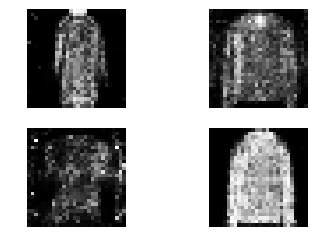

40800 [D loss: 0.694912, acc.: 65.62%] [G loss: 1.003672]


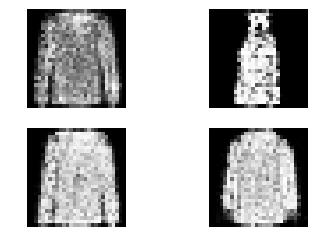

41000 [D loss: 0.548117, acc.: 75.00%] [G loss: 1.044476]


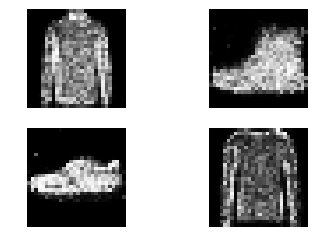

41200 [D loss: 0.643381, acc.: 62.50%] [G loss: 1.055572]


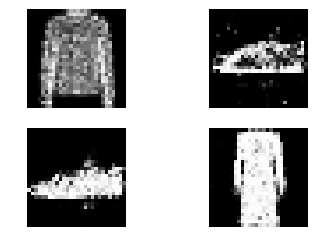

41400 [D loss: 0.691245, acc.: 57.81%] [G loss: 0.927361]


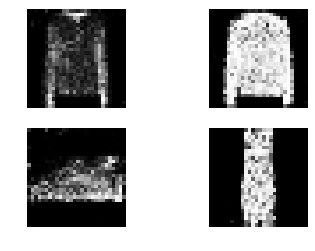

41600 [D loss: 0.672456, acc.: 57.81%] [G loss: 1.035666]


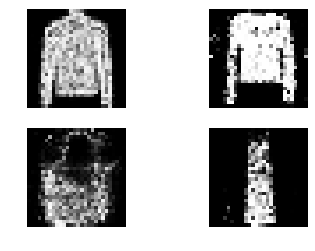

41800 [D loss: 0.649993, acc.: 59.38%] [G loss: 1.082276]


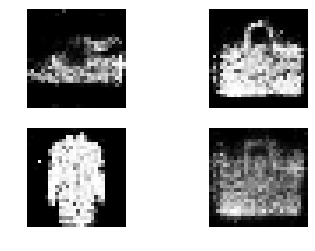

42000 [D loss: 0.645060, acc.: 62.50%] [G loss: 1.050459]


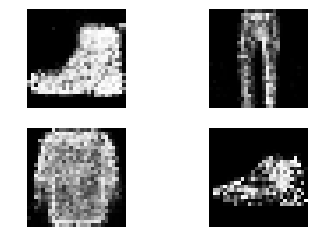

42200 [D loss: 0.694610, acc.: 65.62%] [G loss: 1.038725]


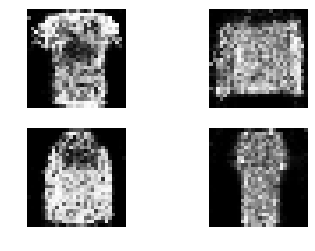

42400 [D loss: 0.590232, acc.: 65.62%] [G loss: 1.059088]


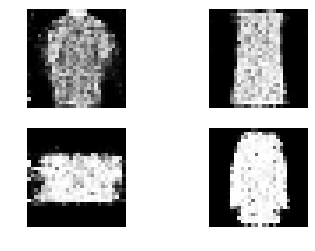

42600 [D loss: 0.644751, acc.: 67.19%] [G loss: 0.968124]


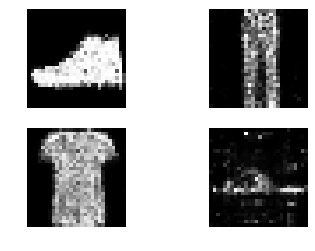

42800 [D loss: 0.638611, acc.: 64.06%] [G loss: 1.120894]


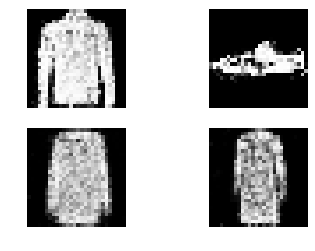

43000 [D loss: 0.569089, acc.: 71.88%] [G loss: 0.938309]


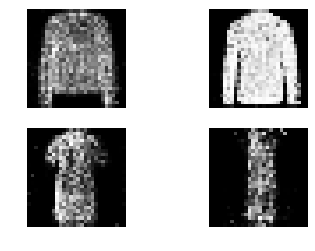

43200 [D loss: 0.582860, acc.: 67.19%] [G loss: 0.953140]


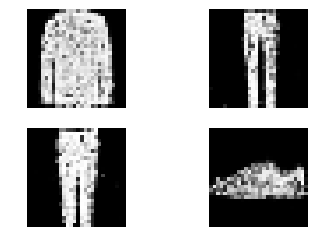

43400 [D loss: 0.637592, acc.: 65.62%] [G loss: 1.110408]


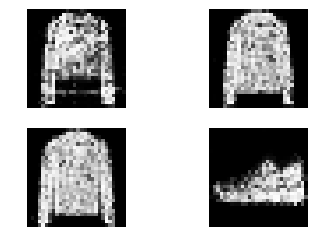

43600 [D loss: 0.510276, acc.: 79.69%] [G loss: 1.024778]


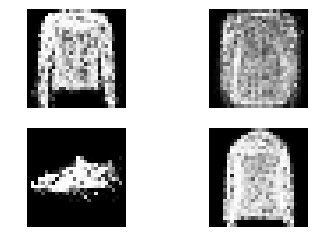

43800 [D loss: 0.530475, acc.: 71.88%] [G loss: 1.014071]


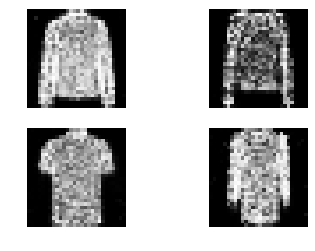

44000 [D loss: 0.627438, acc.: 62.50%] [G loss: 0.997155]


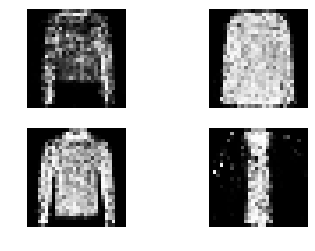

44200 [D loss: 0.502297, acc.: 81.25%] [G loss: 0.945608]


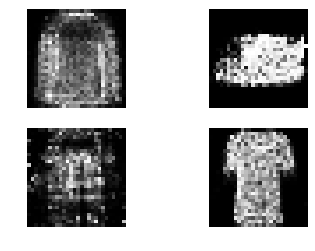

44400 [D loss: 0.636073, acc.: 65.62%] [G loss: 1.021327]


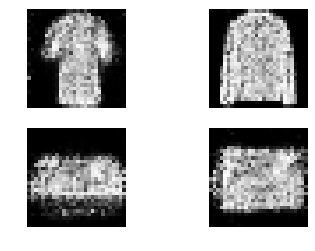

44600 [D loss: 0.619406, acc.: 59.38%] [G loss: 0.941075]


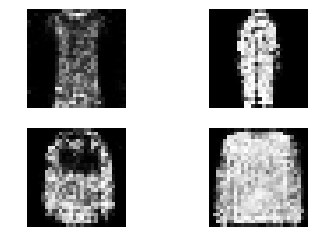

44800 [D loss: 0.701909, acc.: 56.25%] [G loss: 0.904791]


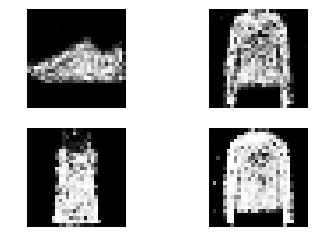

45000 [D loss: 0.669947, acc.: 57.81%] [G loss: 1.094379]


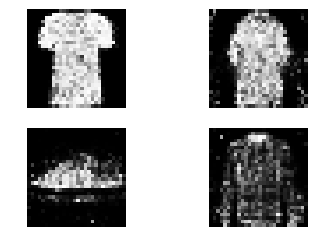

45200 [D loss: 0.646704, acc.: 57.81%] [G loss: 0.924933]


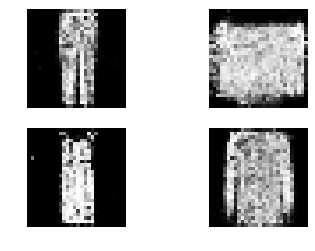

45400 [D loss: 0.643560, acc.: 62.50%] [G loss: 0.991963]


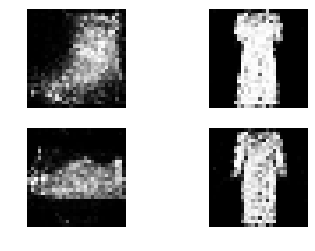

45600 [D loss: 0.511025, acc.: 73.44%] [G loss: 1.028536]


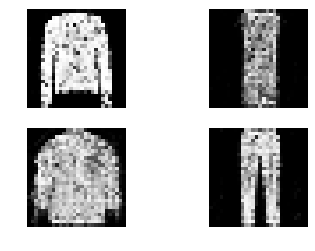

45800 [D loss: 0.625610, acc.: 65.62%] [G loss: 0.881720]


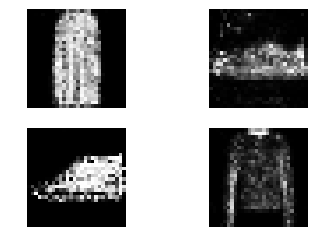

46000 [D loss: 0.546842, acc.: 76.56%] [G loss: 1.005517]


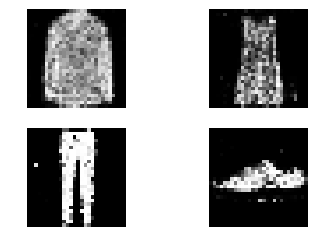

46200 [D loss: 0.550494, acc.: 67.19%] [G loss: 1.053272]


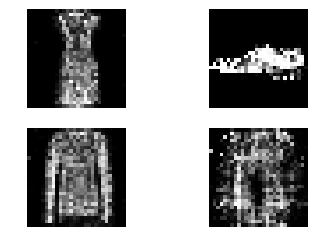

46400 [D loss: 0.518650, acc.: 79.69%] [G loss: 1.076217]


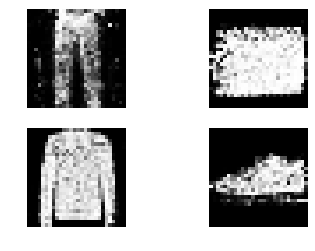

46600 [D loss: 0.595176, acc.: 64.06%] [G loss: 1.006586]


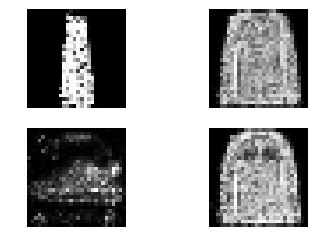

46800 [D loss: 0.618592, acc.: 59.38%] [G loss: 1.208967]


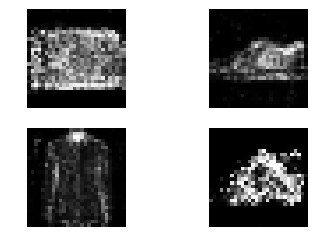

47000 [D loss: 0.641498, acc.: 60.94%] [G loss: 1.068100]


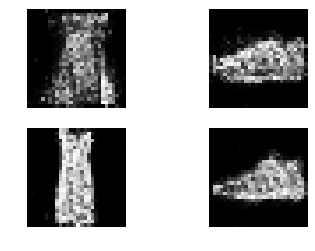

47200 [D loss: 0.553783, acc.: 71.88%] [G loss: 1.078579]


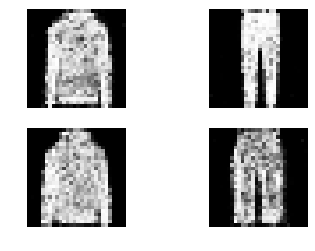

47400 [D loss: 0.643327, acc.: 62.50%] [G loss: 0.961726]


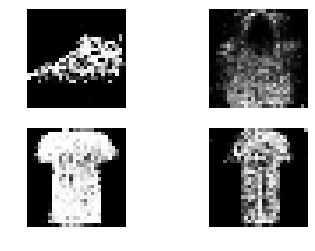

47600 [D loss: 0.589410, acc.: 64.06%] [G loss: 0.994959]


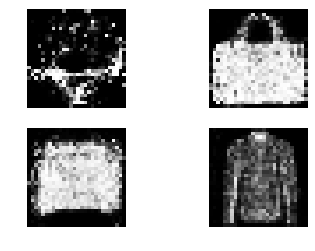

47800 [D loss: 0.752905, acc.: 46.88%] [G loss: 0.959774]


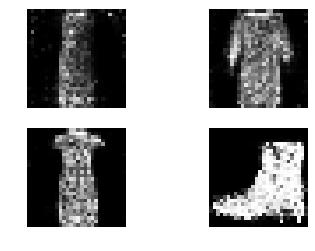

48000 [D loss: 0.606232, acc.: 70.31%] [G loss: 1.075957]


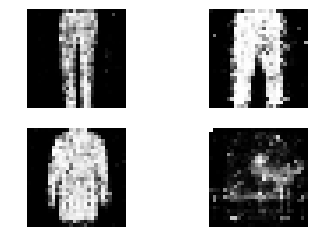

48200 [D loss: 0.600605, acc.: 71.88%] [G loss: 0.967280]


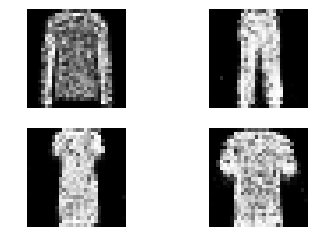

48400 [D loss: 0.566296, acc.: 73.44%] [G loss: 1.026903]


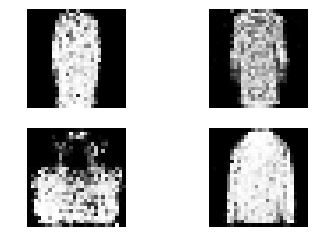

48600 [D loss: 0.639979, acc.: 64.06%] [G loss: 1.028394]


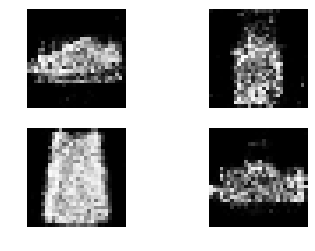

48800 [D loss: 0.649785, acc.: 56.25%] [G loss: 1.079337]


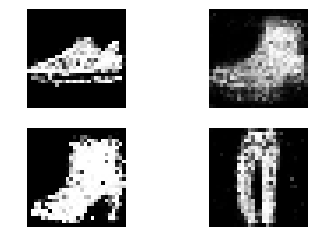

49000 [D loss: 0.589974, acc.: 68.75%] [G loss: 1.068606]


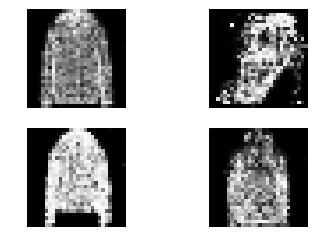

49200 [D loss: 0.647743, acc.: 67.19%] [G loss: 1.047780]


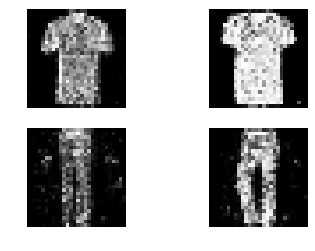

49400 [D loss: 0.566694, acc.: 73.44%] [G loss: 0.900605]


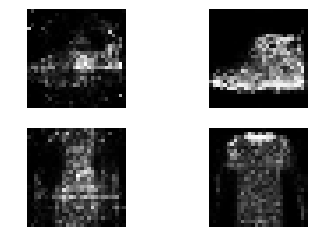

49600 [D loss: 0.627022, acc.: 68.75%] [G loss: 1.047853]


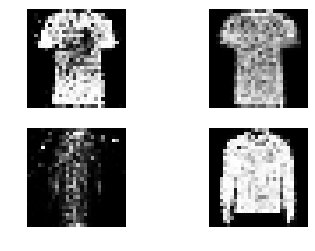

49800 [D loss: 0.683091, acc.: 57.81%] [G loss: 1.103132]


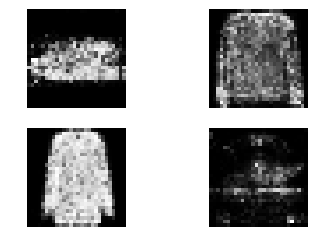

50000 [D loss: 0.572243, acc.: 68.75%] [G loss: 1.124238]


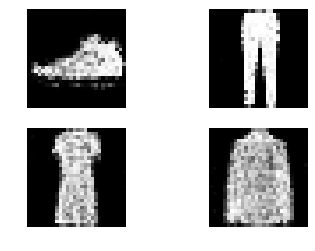

50200 [D loss: 0.639111, acc.: 62.50%] [G loss: 1.086528]


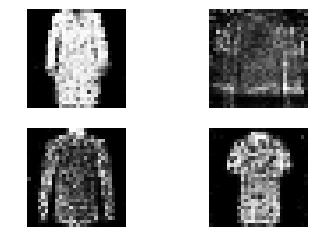

50400 [D loss: 0.603391, acc.: 67.19%] [G loss: 0.997739]


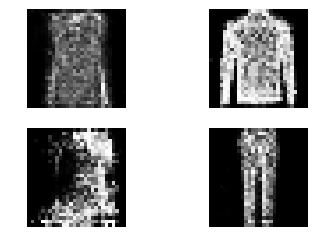

50600 [D loss: 0.666901, acc.: 64.06%] [G loss: 1.059538]


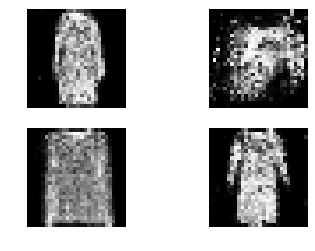

50800 [D loss: 0.655367, acc.: 54.69%] [G loss: 1.143166]


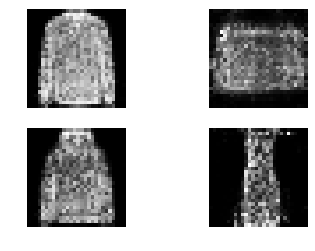

51000 [D loss: 0.687853, acc.: 60.94%] [G loss: 1.093789]


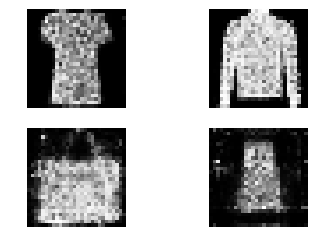

51200 [D loss: 0.587306, acc.: 65.62%] [G loss: 0.962018]


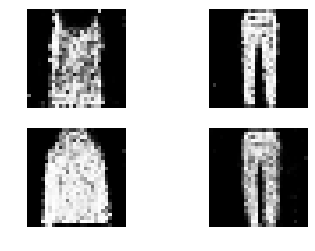

51400 [D loss: 0.684308, acc.: 59.38%] [G loss: 1.071836]


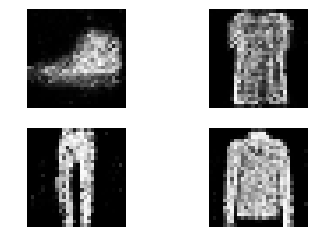

51600 [D loss: 0.579140, acc.: 64.06%] [G loss: 1.076258]


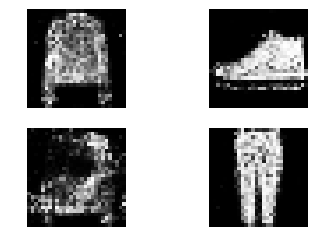

51800 [D loss: 0.682455, acc.: 65.62%] [G loss: 1.081904]


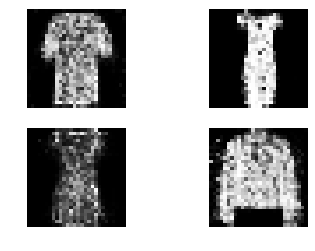

52000 [D loss: 0.518915, acc.: 76.56%] [G loss: 1.244032]


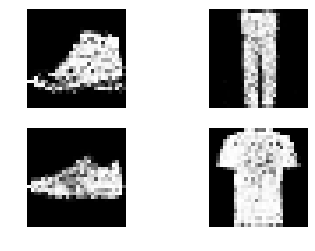

52200 [D loss: 0.647068, acc.: 62.50%] [G loss: 1.140550]


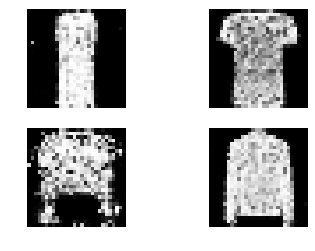

52400 [D loss: 0.597239, acc.: 71.88%] [G loss: 1.084059]


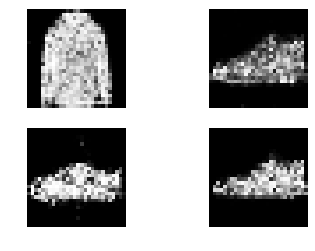

52600 [D loss: 0.541338, acc.: 67.19%] [G loss: 1.116369]


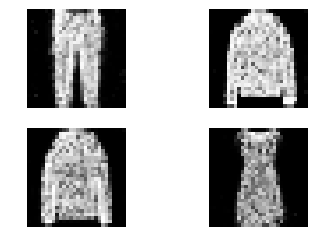

52800 [D loss: 0.627181, acc.: 64.06%] [G loss: 1.175815]


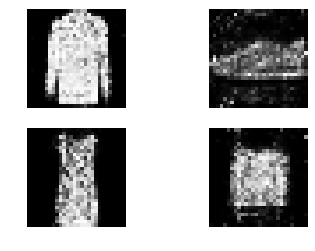

53000 [D loss: 0.654499, acc.: 68.75%] [G loss: 1.091712]


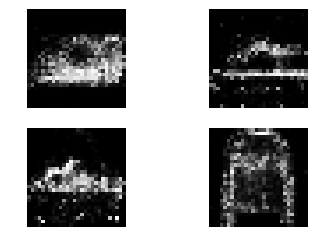

53200 [D loss: 0.556466, acc.: 76.56%] [G loss: 1.150201]


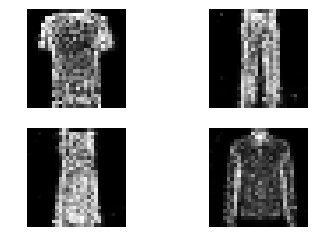

53400 [D loss: 0.664191, acc.: 64.06%] [G loss: 0.998958]


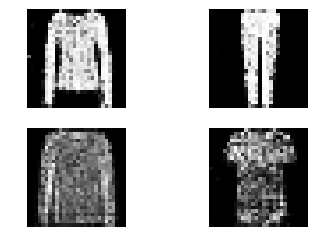

53600 [D loss: 0.742780, acc.: 51.56%] [G loss: 1.092611]


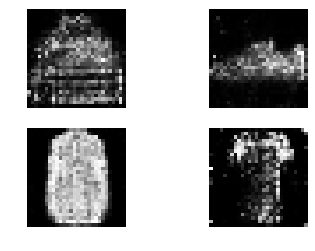

53800 [D loss: 0.607194, acc.: 71.88%] [G loss: 1.095696]


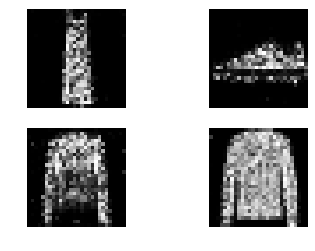

54000 [D loss: 0.654714, acc.: 70.31%] [G loss: 0.907198]


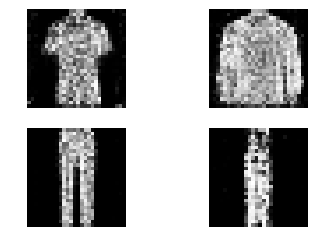

54200 [D loss: 0.602119, acc.: 68.75%] [G loss: 1.063076]


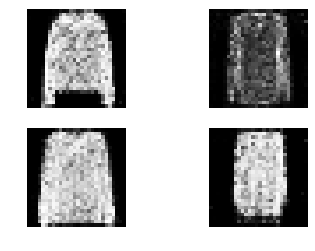

54400 [D loss: 0.613217, acc.: 64.06%] [G loss: 1.103137]


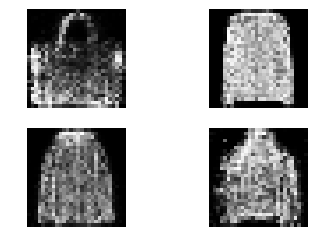

54600 [D loss: 0.579073, acc.: 75.00%] [G loss: 1.017087]


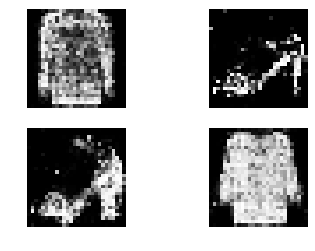

54800 [D loss: 0.599640, acc.: 67.19%] [G loss: 1.136185]


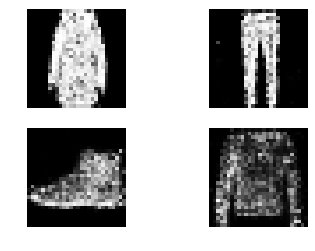

55000 [D loss: 0.605499, acc.: 67.19%] [G loss: 1.014778]


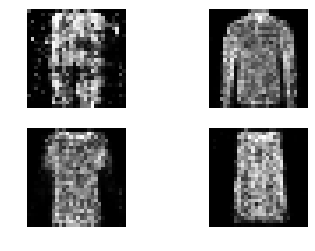

55200 [D loss: 0.650757, acc.: 64.06%] [G loss: 1.080066]


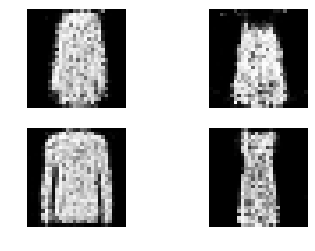

55400 [D loss: 0.545962, acc.: 73.44%] [G loss: 1.072154]


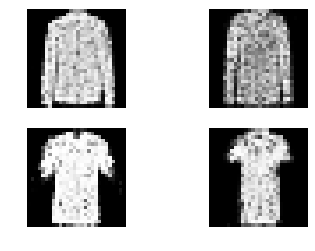

55600 [D loss: 0.618785, acc.: 64.06%] [G loss: 1.171032]


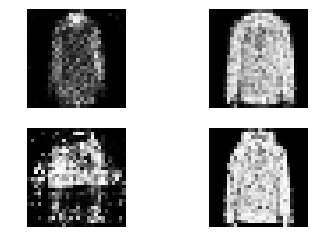

55800 [D loss: 0.547723, acc.: 68.75%] [G loss: 1.127323]


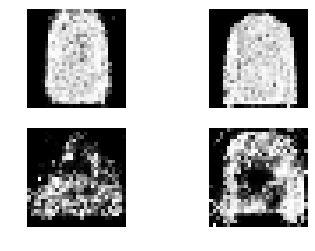

56000 [D loss: 0.727754, acc.: 50.00%] [G loss: 1.042896]


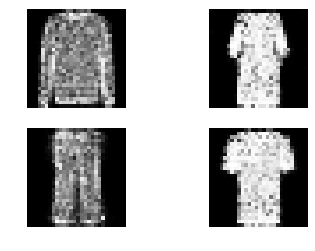

56200 [D loss: 0.616081, acc.: 68.75%] [G loss: 1.083747]


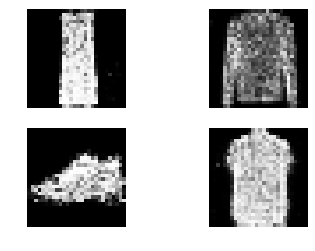

56400 [D loss: 0.565586, acc.: 75.00%] [G loss: 1.123652]


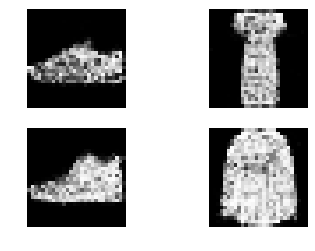

56600 [D loss: 0.680521, acc.: 62.50%] [G loss: 1.167277]


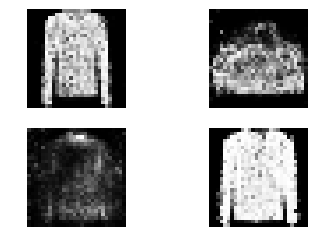

56800 [D loss: 0.506940, acc.: 79.69%] [G loss: 1.113477]


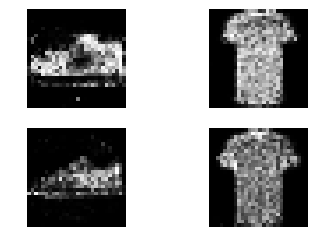

57000 [D loss: 0.714134, acc.: 48.44%] [G loss: 0.925952]


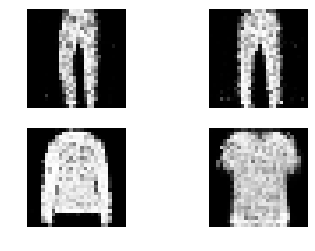

57200 [D loss: 0.613654, acc.: 60.94%] [G loss: 1.185930]


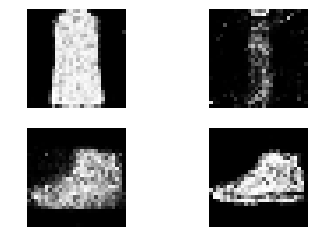

57400 [D loss: 0.738989, acc.: 50.00%] [G loss: 0.875855]


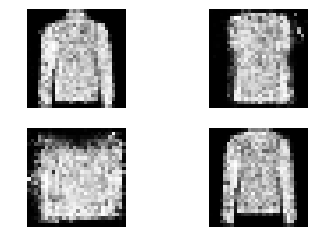

57600 [D loss: 0.650938, acc.: 54.69%] [G loss: 1.157514]


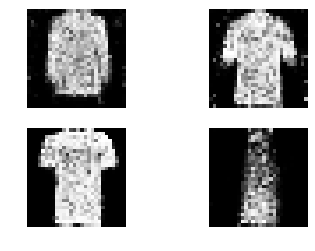

57800 [D loss: 0.633719, acc.: 62.50%] [G loss: 1.146541]


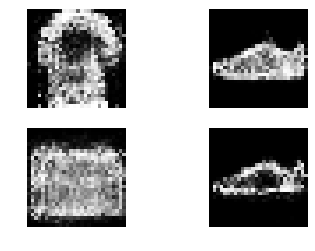

58000 [D loss: 0.575470, acc.: 67.19%] [G loss: 1.163442]


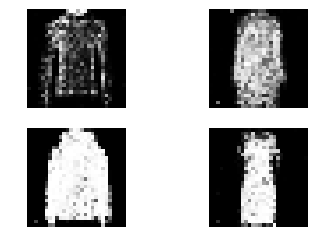

58200 [D loss: 0.528105, acc.: 76.56%] [G loss: 1.022371]


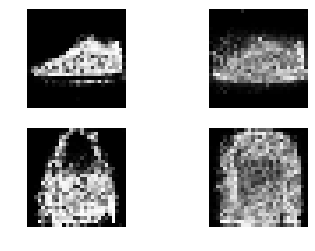

58400 [D loss: 0.655790, acc.: 57.81%] [G loss: 1.061997]


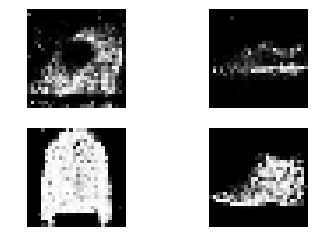

58600 [D loss: 0.524410, acc.: 75.00%] [G loss: 1.098344]


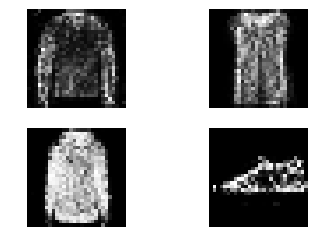

58800 [D loss: 0.652325, acc.: 68.75%] [G loss: 0.993798]


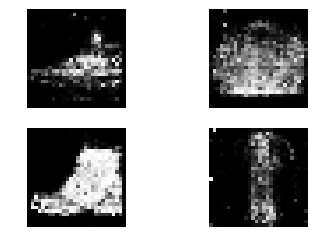

59000 [D loss: 0.597721, acc.: 70.31%] [G loss: 1.059451]


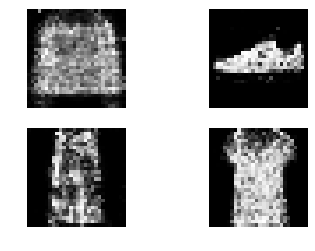

59200 [D loss: 0.488348, acc.: 79.69%] [G loss: 1.191639]


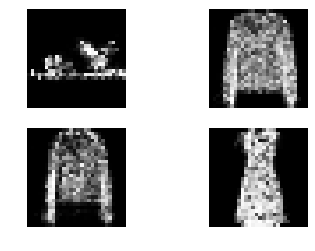

59400 [D loss: 0.774631, acc.: 46.88%] [G loss: 1.104369]


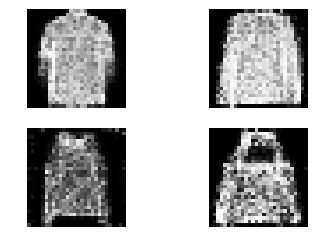

59600 [D loss: 0.580106, acc.: 71.88%] [G loss: 1.038977]


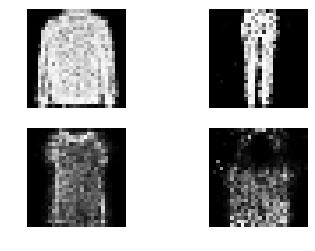

59800 [D loss: 0.577792, acc.: 68.75%] [G loss: 1.155692]


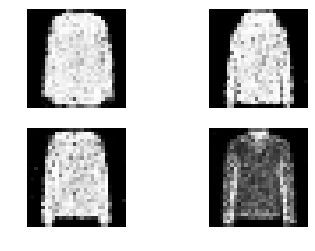

60000 [D loss: 0.634106, acc.: 67.19%] [G loss: 1.103209]


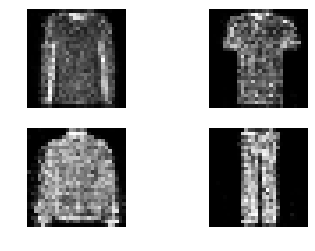

60200 [D loss: 0.559865, acc.: 76.56%] [G loss: 1.271718]


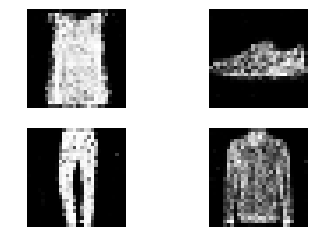

60400 [D loss: 0.565119, acc.: 70.31%] [G loss: 1.257694]


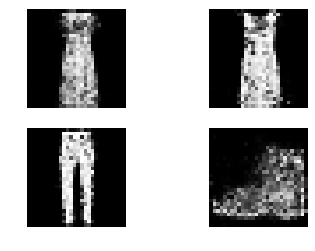

60600 [D loss: 0.584433, acc.: 62.50%] [G loss: 1.117289]


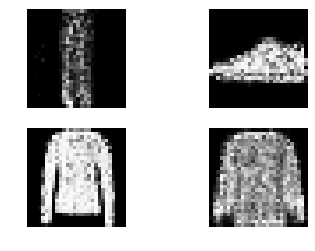

60800 [D loss: 0.497782, acc.: 79.69%] [G loss: 1.166608]


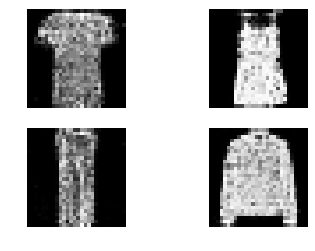

61000 [D loss: 0.621805, acc.: 60.94%] [G loss: 1.161570]


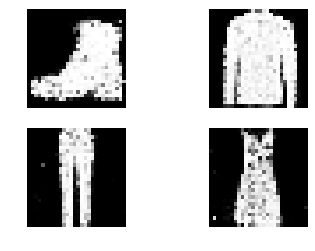

61200 [D loss: 0.641451, acc.: 60.94%] [G loss: 1.097618]


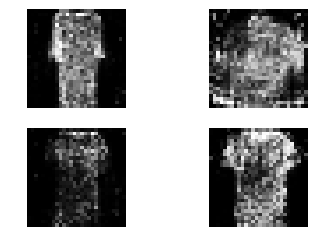

61400 [D loss: 0.549431, acc.: 67.19%] [G loss: 1.139399]


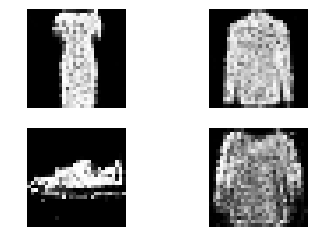

61600 [D loss: 0.591550, acc.: 73.44%] [G loss: 1.190523]


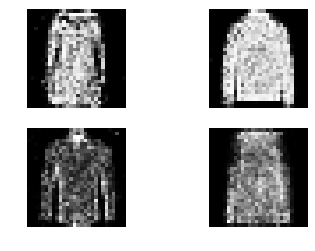

61800 [D loss: 0.680654, acc.: 60.94%] [G loss: 0.895700]


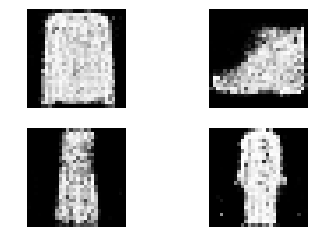

62000 [D loss: 0.636575, acc.: 64.06%] [G loss: 1.001205]


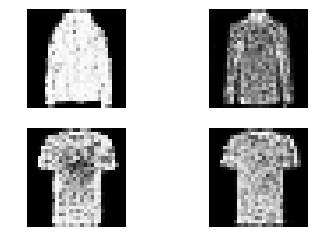

62200 [D loss: 0.646702, acc.: 62.50%] [G loss: 1.063384]


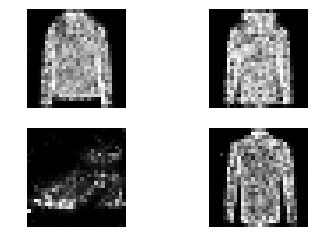

62400 [D loss: 0.553617, acc.: 67.19%] [G loss: 0.953786]


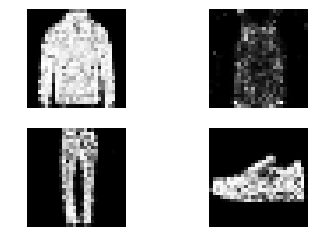

62600 [D loss: 0.593273, acc.: 70.31%] [G loss: 1.195392]


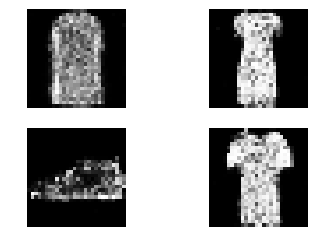

62800 [D loss: 0.690770, acc.: 54.69%] [G loss: 1.179015]


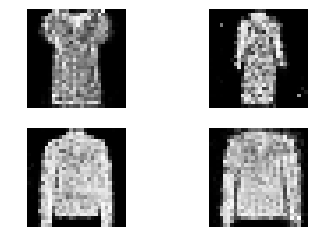

63000 [D loss: 0.603664, acc.: 70.31%] [G loss: 1.180574]


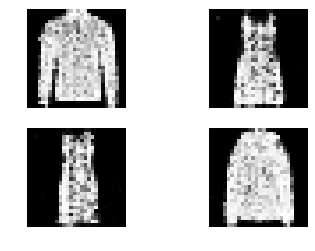

63200 [D loss: 0.615422, acc.: 67.19%] [G loss: 1.106393]


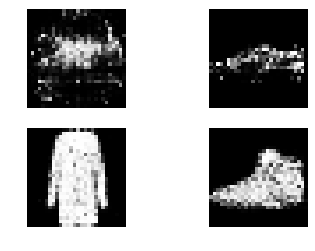

63400 [D loss: 0.558323, acc.: 64.06%] [G loss: 1.054295]


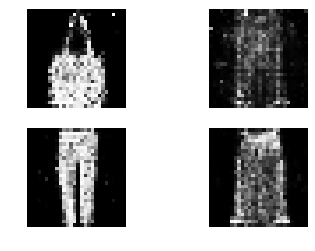

63600 [D loss: 0.735753, acc.: 54.69%] [G loss: 1.146803]


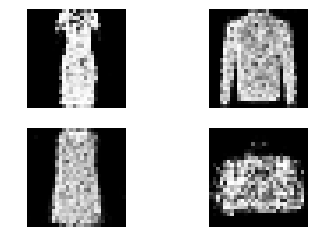

63800 [D loss: 0.567790, acc.: 68.75%] [G loss: 1.057452]


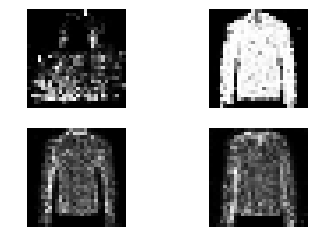

64000 [D loss: 0.614445, acc.: 67.19%] [G loss: 0.963472]


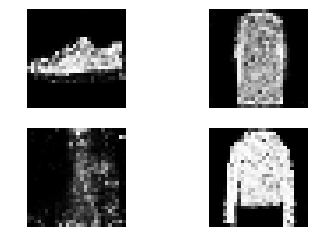

64200 [D loss: 0.593115, acc.: 65.62%] [G loss: 1.189898]


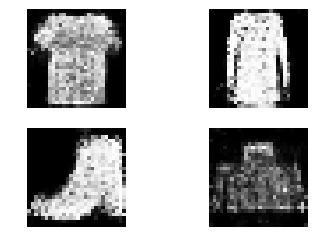

64400 [D loss: 0.558273, acc.: 71.88%] [G loss: 1.149772]


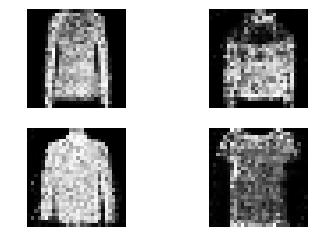

64600 [D loss: 0.547020, acc.: 73.44%] [G loss: 1.155314]


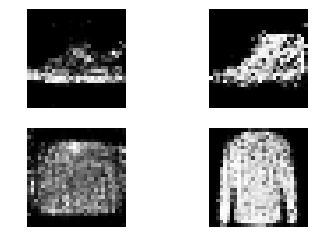

64800 [D loss: 0.542779, acc.: 73.44%] [G loss: 1.221285]


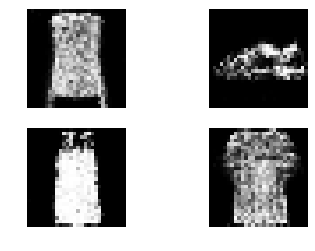

65000 [D loss: 0.663210, acc.: 57.81%] [G loss: 1.117231]


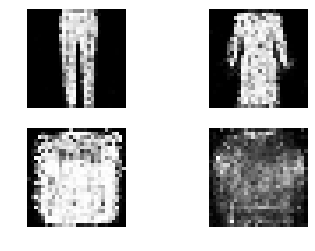

65200 [D loss: 0.658780, acc.: 67.19%] [G loss: 1.170158]


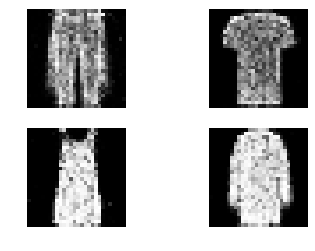

65400 [D loss: 0.578838, acc.: 68.75%] [G loss: 1.062223]


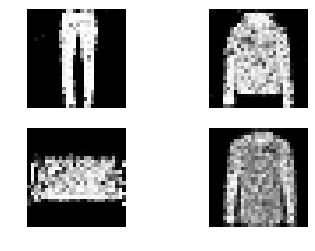

65600 [D loss: 0.567678, acc.: 65.62%] [G loss: 1.063917]


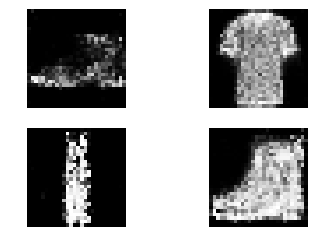

65800 [D loss: 0.626521, acc.: 65.62%] [G loss: 1.080785]


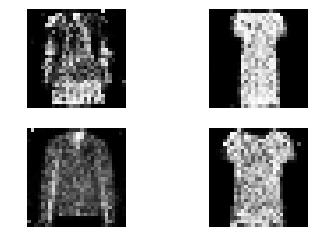

66000 [D loss: 0.632143, acc.: 70.31%] [G loss: 1.167271]


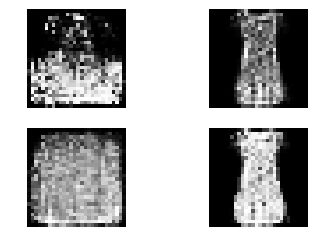

66200 [D loss: 0.676778, acc.: 54.69%] [G loss: 1.090589]


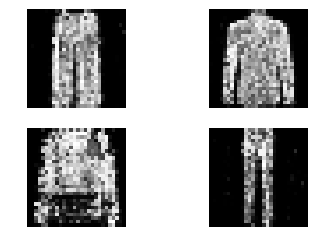

66400 [D loss: 0.512527, acc.: 75.00%] [G loss: 1.106671]


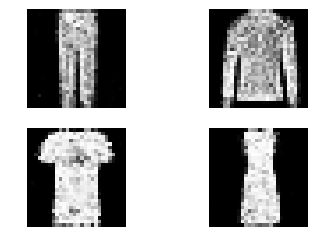

66600 [D loss: 0.671659, acc.: 57.81%] [G loss: 1.187893]


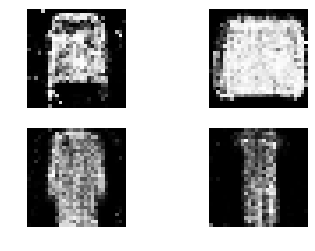

66800 [D loss: 0.535351, acc.: 68.75%] [G loss: 1.144670]


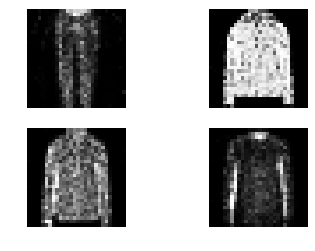

67000 [D loss: 0.588017, acc.: 67.19%] [G loss: 1.179138]


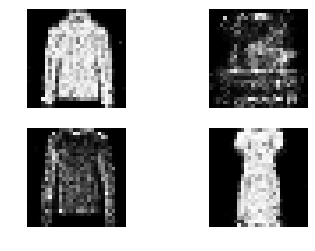

67200 [D loss: 0.500597, acc.: 76.56%] [G loss: 1.118672]


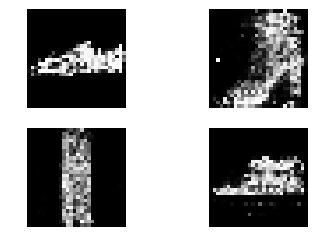

67400 [D loss: 0.665318, acc.: 59.38%] [G loss: 1.321711]


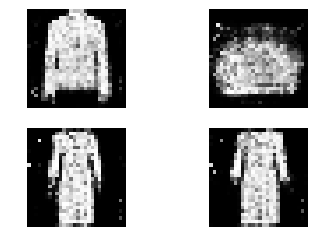

67600 [D loss: 0.564483, acc.: 75.00%] [G loss: 1.117113]


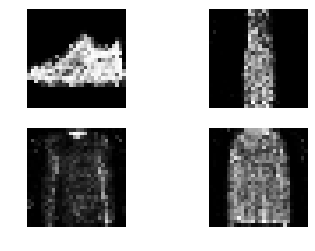

67800 [D loss: 0.603606, acc.: 59.38%] [G loss: 0.984190]


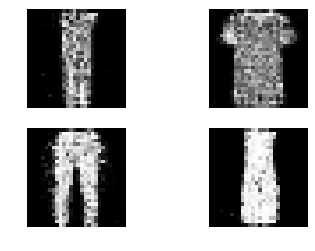

68000 [D loss: 0.747872, acc.: 51.56%] [G loss: 1.085346]


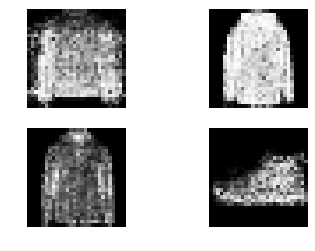

68200 [D loss: 0.535616, acc.: 75.00%] [G loss: 1.180352]


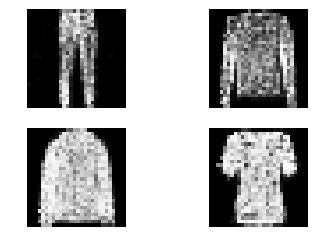

68400 [D loss: 0.574755, acc.: 68.75%] [G loss: 1.016193]


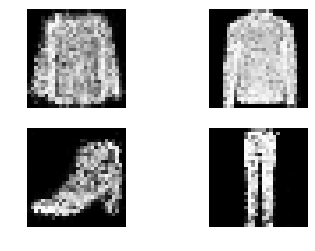

68600 [D loss: 0.605607, acc.: 59.38%] [G loss: 1.204088]


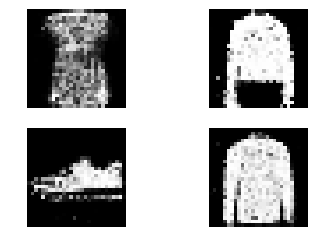

68800 [D loss: 0.650444, acc.: 54.69%] [G loss: 1.138216]


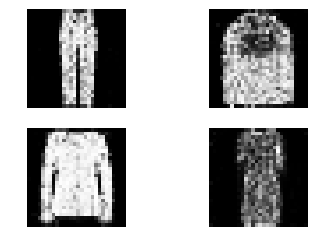

69000 [D loss: 0.685860, acc.: 62.50%] [G loss: 1.077746]


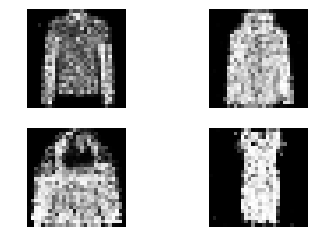

69200 [D loss: 0.713314, acc.: 51.56%] [G loss: 1.276362]


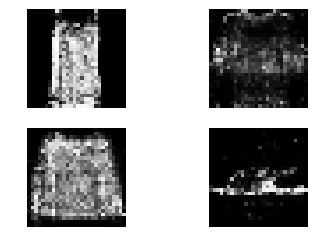

69400 [D loss: 0.544882, acc.: 73.44%] [G loss: 1.082630]


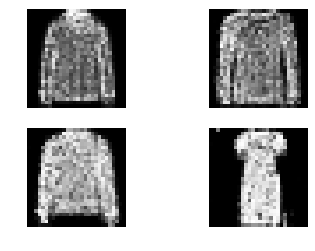

69600 [D loss: 0.580391, acc.: 68.75%] [G loss: 1.062047]


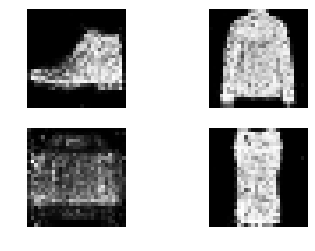

69800 [D loss: 0.576359, acc.: 67.19%] [G loss: 1.168091]


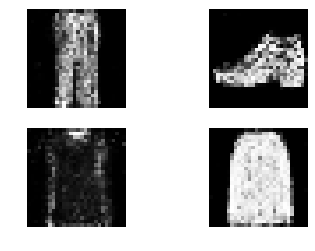

70000 [D loss: 0.717667, acc.: 56.25%] [G loss: 1.112700]


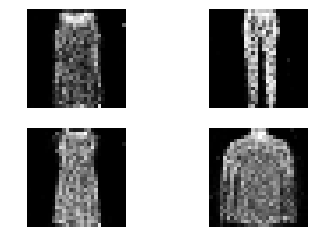

70200 [D loss: 0.565693, acc.: 70.31%] [G loss: 1.174307]


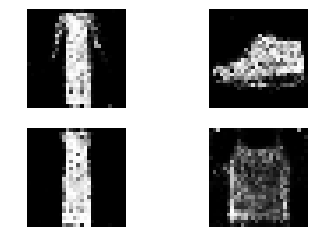

70400 [D loss: 0.555390, acc.: 75.00%] [G loss: 1.074648]


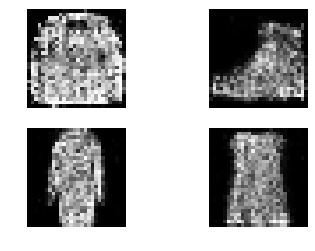

70600 [D loss: 0.541961, acc.: 73.44%] [G loss: 1.132161]


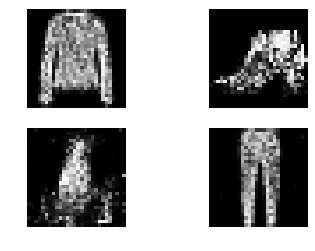

70800 [D loss: 0.535433, acc.: 71.88%] [G loss: 1.164131]


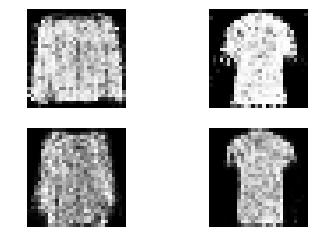

71000 [D loss: 0.578149, acc.: 71.88%] [G loss: 1.035608]


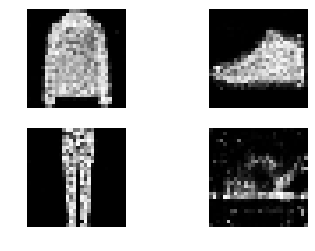

71200 [D loss: 0.567692, acc.: 71.88%] [G loss: 1.279499]


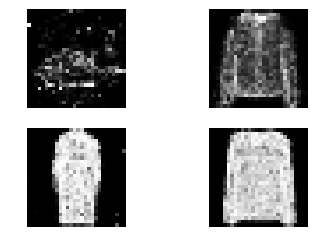

71400 [D loss: 0.622682, acc.: 65.62%] [G loss: 1.100348]


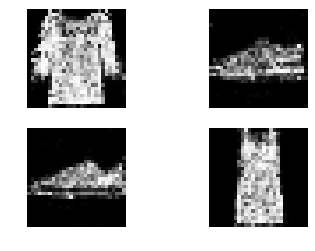

71600 [D loss: 0.534419, acc.: 78.12%] [G loss: 1.185029]


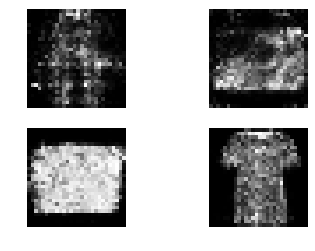

71800 [D loss: 0.651281, acc.: 65.62%] [G loss: 1.091757]


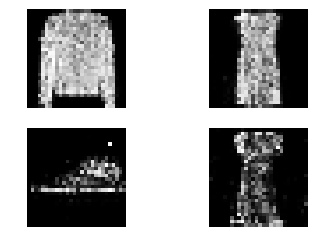

72000 [D loss: 0.574018, acc.: 65.62%] [G loss: 1.418195]


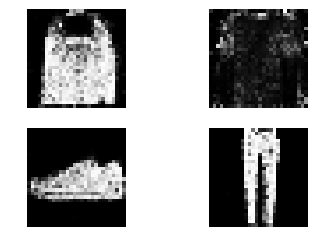

72200 [D loss: 0.623989, acc.: 60.94%] [G loss: 1.039833]


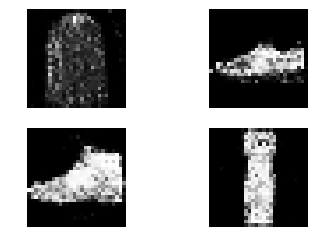

72400 [D loss: 0.647749, acc.: 64.06%] [G loss: 1.148576]


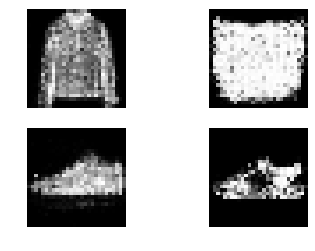

72600 [D loss: 0.659730, acc.: 54.69%] [G loss: 1.095356]


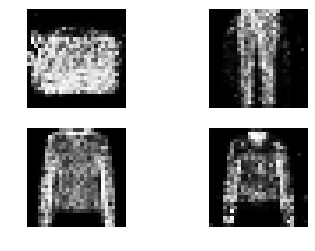

72800 [D loss: 0.557264, acc.: 68.75%] [G loss: 1.244149]


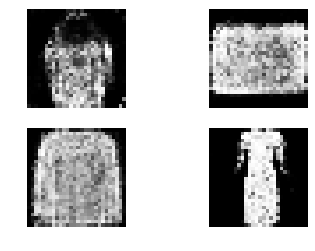

73000 [D loss: 0.678636, acc.: 53.12%] [G loss: 1.218711]


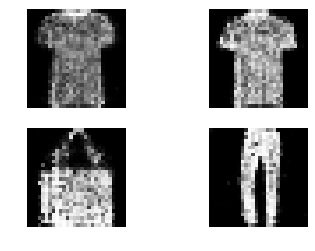

73200 [D loss: 0.540033, acc.: 68.75%] [G loss: 1.047047]


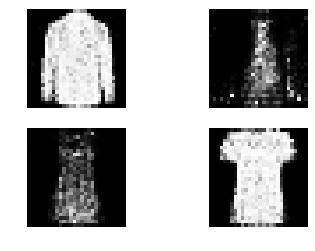

73400 [D loss: 0.626727, acc.: 59.38%] [G loss: 1.062130]


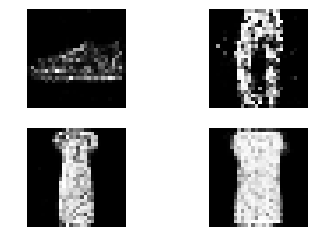

73600 [D loss: 0.542069, acc.: 71.88%] [G loss: 1.202765]


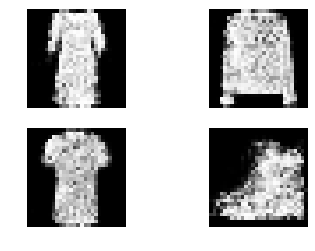

73800 [D loss: 0.575303, acc.: 57.81%] [G loss: 1.003941]


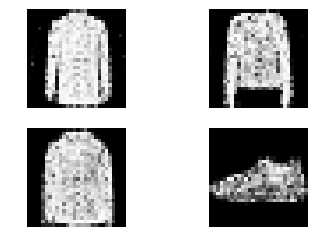

74000 [D loss: 0.560896, acc.: 75.00%] [G loss: 1.279828]


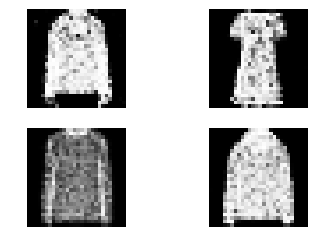

74200 [D loss: 0.676584, acc.: 65.62%] [G loss: 1.116187]


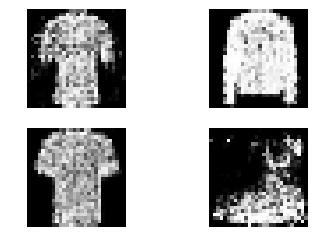

74400 [D loss: 0.578647, acc.: 75.00%] [G loss: 1.134364]


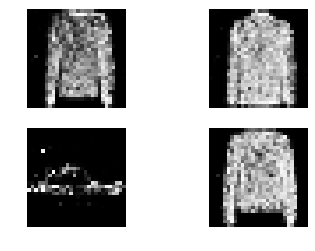

74600 [D loss: 0.545186, acc.: 71.88%] [G loss: 1.238872]


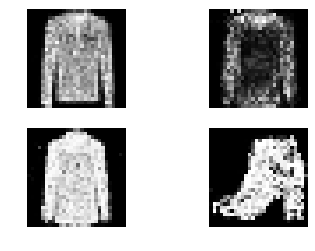

74800 [D loss: 0.469849, acc.: 79.69%] [G loss: 1.188997]


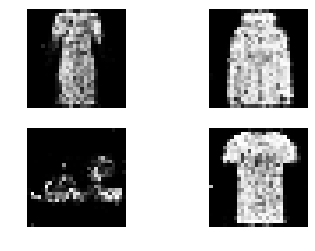

75000 [D loss: 0.552782, acc.: 70.31%] [G loss: 1.053699]


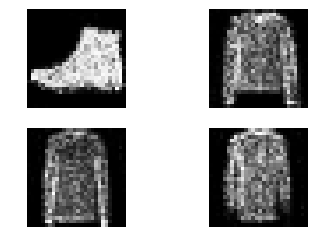

75200 [D loss: 0.613356, acc.: 62.50%] [G loss: 1.000056]


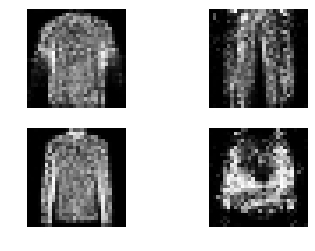

75400 [D loss: 0.602357, acc.: 70.31%] [G loss: 1.064510]


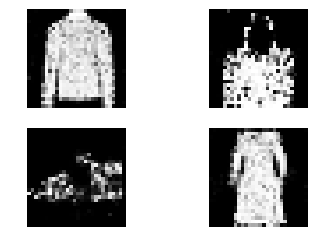

75600 [D loss: 0.613113, acc.: 64.06%] [G loss: 1.113658]


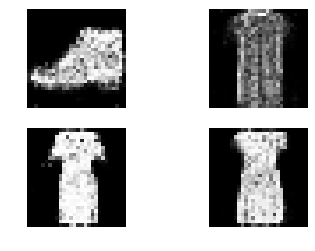

75800 [D loss: 0.580617, acc.: 68.75%] [G loss: 1.256886]


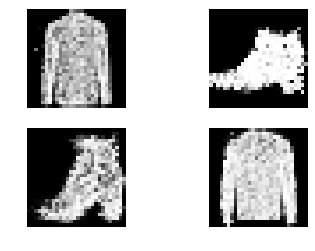

76000 [D loss: 0.557007, acc.: 73.44%] [G loss: 1.078812]


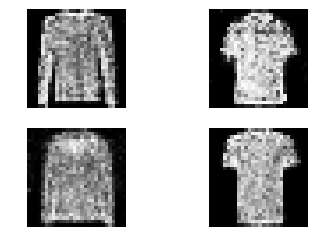

76200 [D loss: 0.654837, acc.: 68.75%] [G loss: 1.184701]


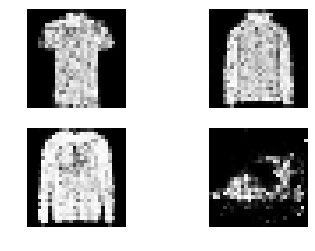

76400 [D loss: 0.591976, acc.: 68.75%] [G loss: 1.068578]


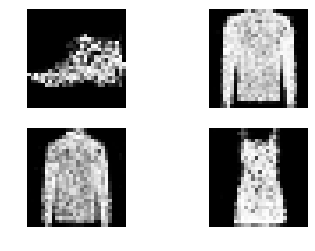

76600 [D loss: 0.471818, acc.: 78.12%] [G loss: 0.927495]


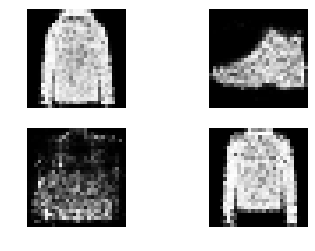

76800 [D loss: 0.534302, acc.: 78.12%] [G loss: 1.151408]


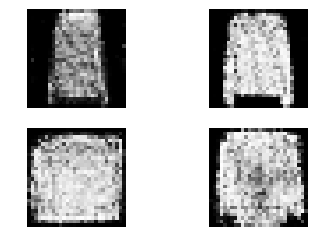

77000 [D loss: 0.590600, acc.: 65.62%] [G loss: 1.179596]


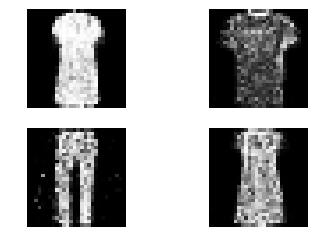

77200 [D loss: 0.582196, acc.: 68.75%] [G loss: 1.178430]


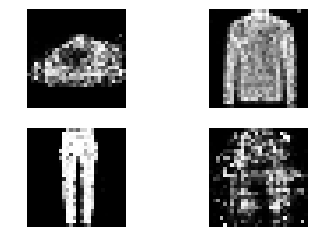

77400 [D loss: 0.640126, acc.: 64.06%] [G loss: 1.133448]


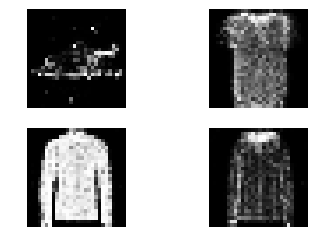

77600 [D loss: 0.550150, acc.: 73.44%] [G loss: 1.341255]


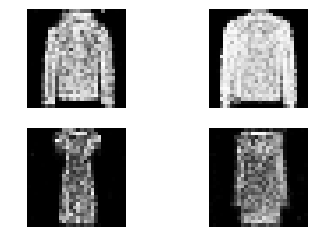

77800 [D loss: 0.588986, acc.: 60.94%] [G loss: 1.213395]


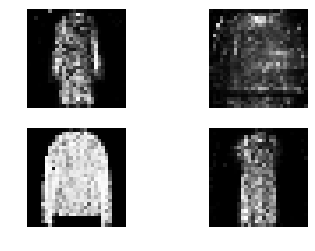

78000 [D loss: 0.650306, acc.: 62.50%] [G loss: 1.089346]


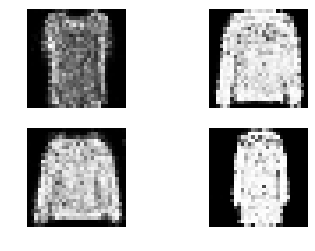

78200 [D loss: 0.531045, acc.: 71.88%] [G loss: 1.166952]


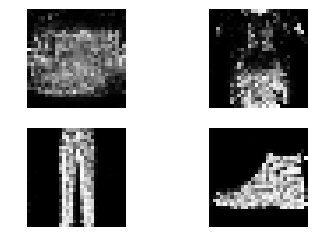

78400 [D loss: 0.474508, acc.: 81.25%] [G loss: 1.240910]


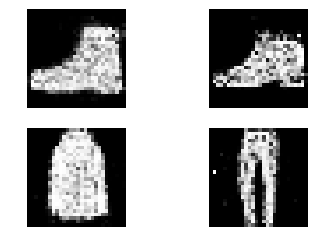

78600 [D loss: 0.695498, acc.: 59.38%] [G loss: 1.260536]


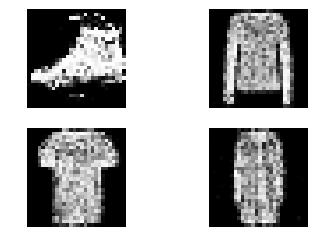

78800 [D loss: 0.478150, acc.: 79.69%] [G loss: 1.087839]


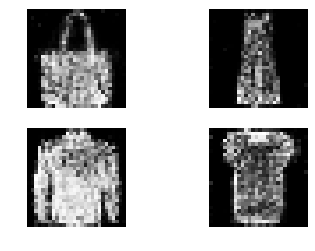

79000 [D loss: 0.534842, acc.: 73.44%] [G loss: 1.418688]


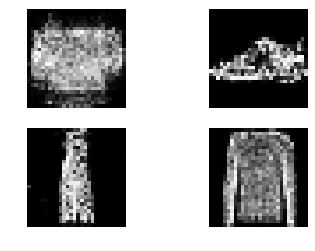

79200 [D loss: 0.688430, acc.: 51.56%] [G loss: 1.149095]


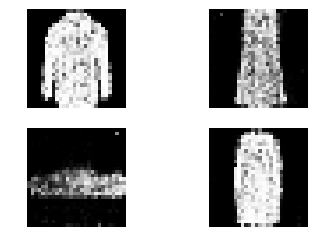

79400 [D loss: 0.617655, acc.: 60.94%] [G loss: 1.212066]


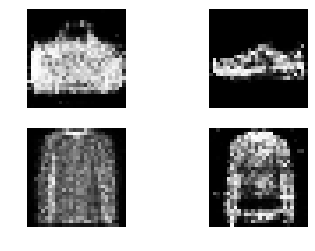

79600 [D loss: 0.549370, acc.: 68.75%] [G loss: 1.188098]


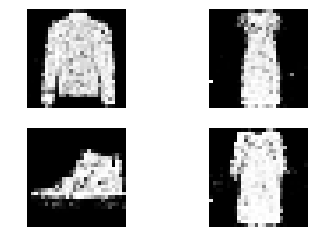

79800 [D loss: 0.654398, acc.: 62.50%] [G loss: 1.299362]


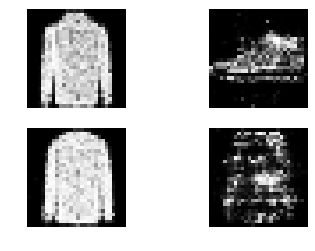

80000 [D loss: 0.623443, acc.: 65.62%] [G loss: 1.317465]


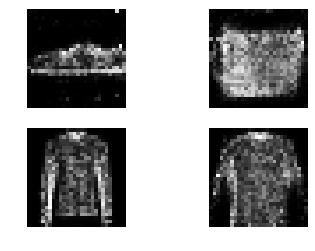

80200 [D loss: 0.660506, acc.: 64.06%] [G loss: 1.094914]


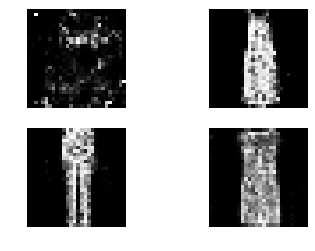

80400 [D loss: 0.587741, acc.: 68.75%] [G loss: 1.206374]


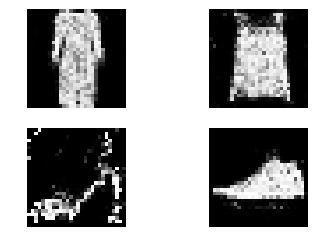

80600 [D loss: 0.561226, acc.: 71.88%] [G loss: 1.049866]


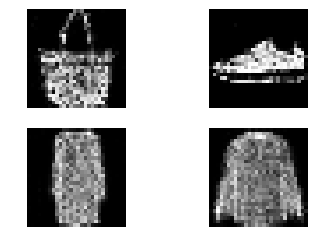

80800 [D loss: 0.518898, acc.: 71.88%] [G loss: 1.038646]


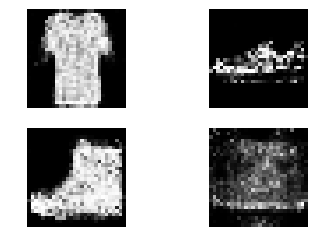

81000 [D loss: 0.494084, acc.: 76.56%] [G loss: 1.361027]


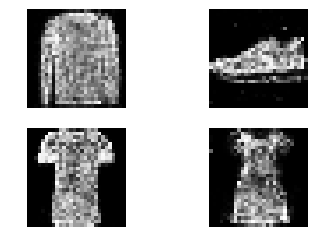

81200 [D loss: 0.619464, acc.: 62.50%] [G loss: 1.203934]


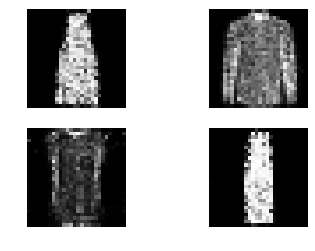

81400 [D loss: 0.651935, acc.: 60.94%] [G loss: 1.159371]


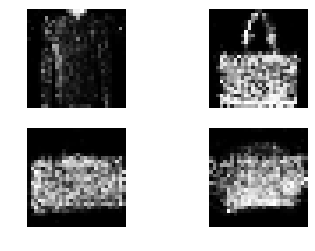

81600 [D loss: 0.558498, acc.: 70.31%] [G loss: 0.848745]


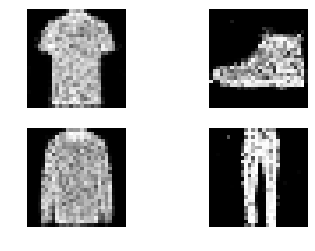

81800 [D loss: 0.492966, acc.: 81.25%] [G loss: 1.244636]


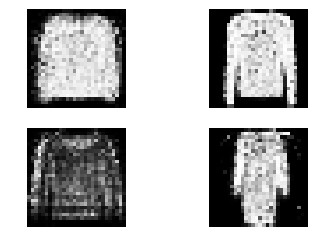

82000 [D loss: 0.573763, acc.: 75.00%] [G loss: 1.222955]


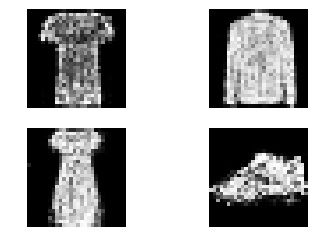

82200 [D loss: 0.556607, acc.: 71.88%] [G loss: 1.110355]


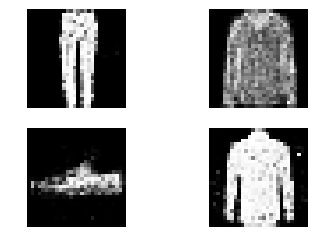

82400 [D loss: 0.617844, acc.: 67.19%] [G loss: 1.071185]


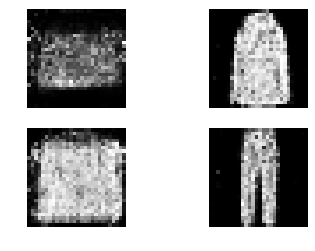

82600 [D loss: 0.622056, acc.: 57.81%] [G loss: 1.145963]


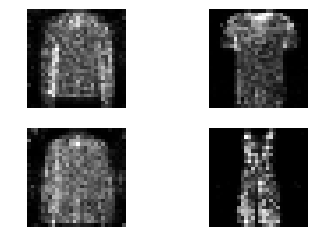

82800 [D loss: 0.565263, acc.: 65.62%] [G loss: 1.044281]


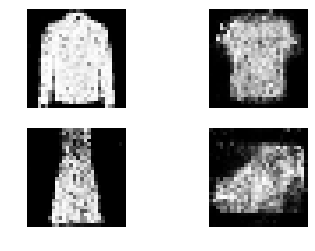

83000 [D loss: 0.639719, acc.: 62.50%] [G loss: 1.138356]


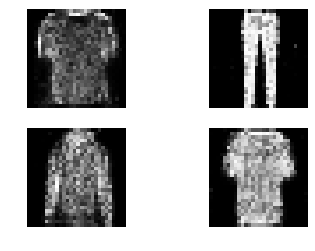

83200 [D loss: 0.566931, acc.: 70.31%] [G loss: 1.297946]


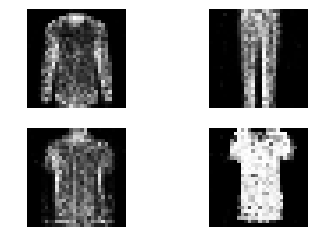

83400 [D loss: 0.568735, acc.: 73.44%] [G loss: 1.171324]


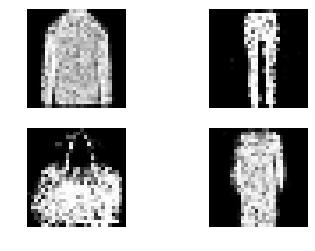

83600 [D loss: 0.569329, acc.: 71.88%] [G loss: 1.103918]


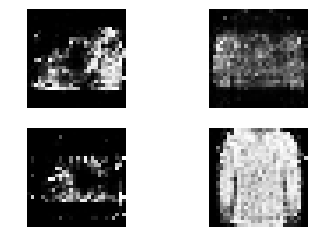

83800 [D loss: 0.598389, acc.: 67.19%] [G loss: 1.246919]


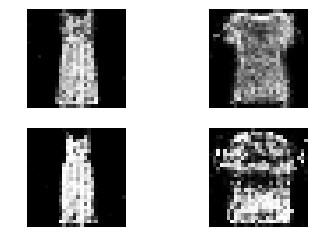

84000 [D loss: 0.638328, acc.: 64.06%] [G loss: 1.103263]


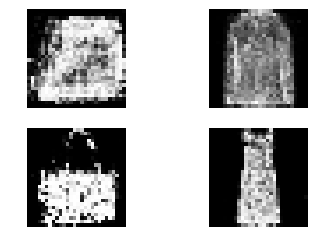

84200 [D loss: 0.623360, acc.: 62.50%] [G loss: 1.239521]


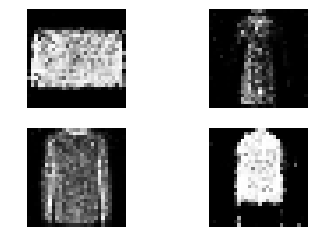

84400 [D loss: 0.676873, acc.: 50.00%] [G loss: 1.059325]


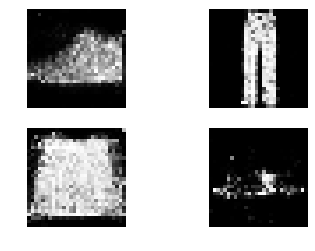

84600 [D loss: 0.557218, acc.: 75.00%] [G loss: 1.237364]


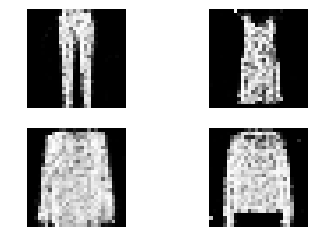

84800 [D loss: 0.522811, acc.: 76.56%] [G loss: 1.275132]


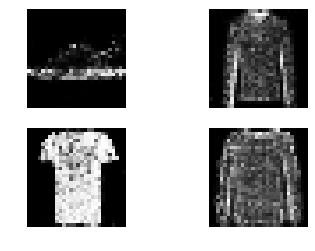

85000 [D loss: 0.602217, acc.: 62.50%] [G loss: 1.052339]


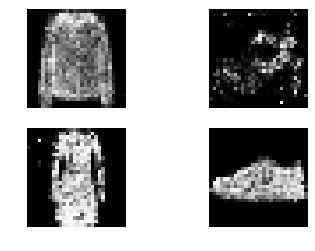

85200 [D loss: 0.654598, acc.: 57.81%] [G loss: 1.200573]


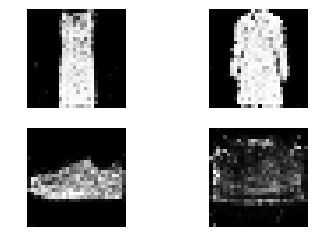

85400 [D loss: 0.542202, acc.: 75.00%] [G loss: 1.203217]


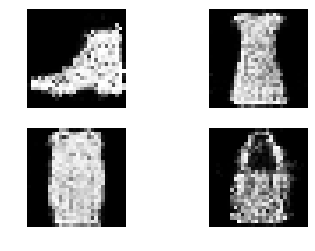

85600 [D loss: 0.470100, acc.: 78.12%] [G loss: 1.238012]


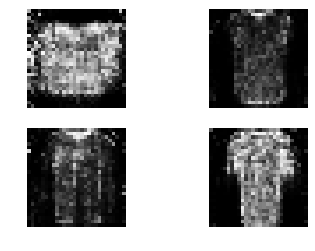

85800 [D loss: 0.648339, acc.: 56.25%] [G loss: 1.146040]


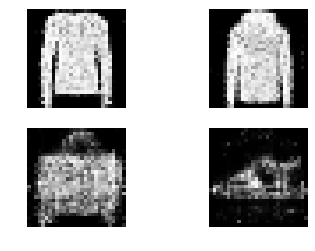

86000 [D loss: 0.549304, acc.: 73.44%] [G loss: 1.279803]


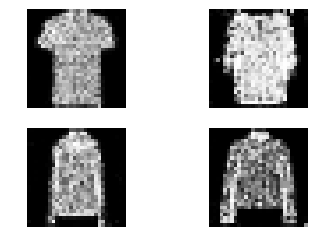

86200 [D loss: 0.548812, acc.: 67.19%] [G loss: 1.238540]


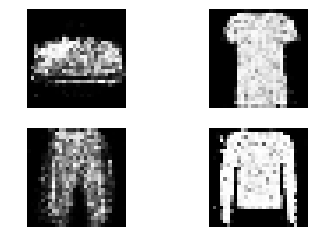

86400 [D loss: 0.586515, acc.: 71.88%] [G loss: 1.042723]


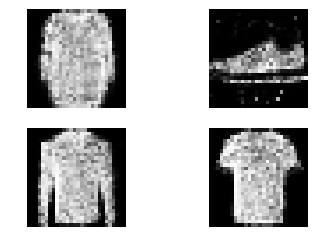

86600 [D loss: 0.507129, acc.: 73.44%] [G loss: 1.366163]


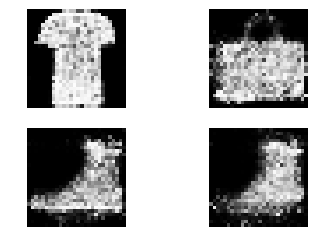

86800 [D loss: 0.514557, acc.: 78.12%] [G loss: 1.376214]


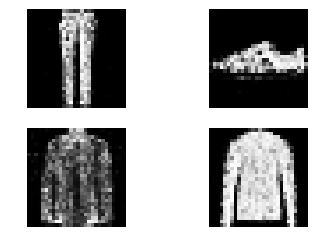

87000 [D loss: 0.477331, acc.: 75.00%] [G loss: 1.275702]


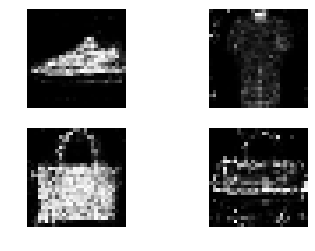

87200 [D loss: 0.559181, acc.: 71.88%] [G loss: 1.096439]


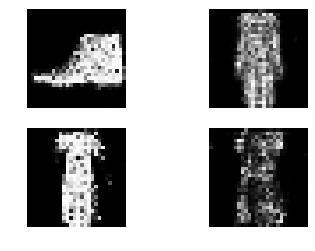

87400 [D loss: 0.559239, acc.: 71.88%] [G loss: 1.409322]


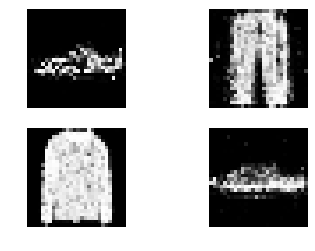

87600 [D loss: 0.594497, acc.: 65.62%] [G loss: 1.138773]


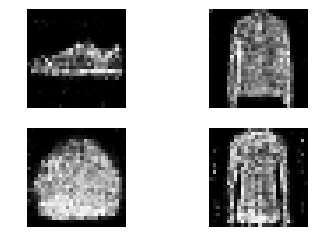

87800 [D loss: 0.515560, acc.: 81.25%] [G loss: 1.190540]


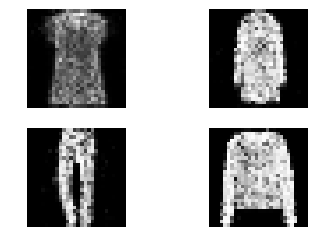

88000 [D loss: 0.528180, acc.: 71.88%] [G loss: 1.338426]


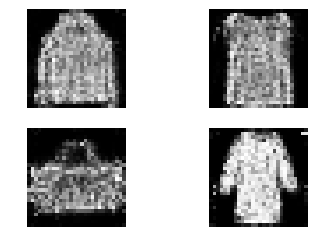

88200 [D loss: 0.584133, acc.: 65.62%] [G loss: 1.222411]


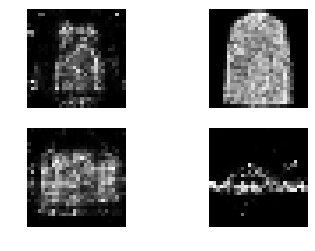

88400 [D loss: 0.596621, acc.: 65.62%] [G loss: 1.173354]


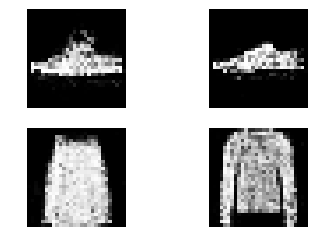

88600 [D loss: 0.665088, acc.: 59.38%] [G loss: 1.308189]


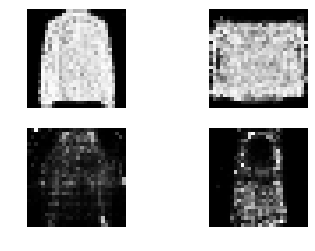

88800 [D loss: 0.616498, acc.: 62.50%] [G loss: 1.295778]


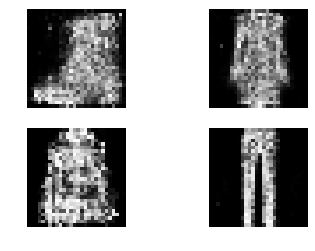

89000 [D loss: 0.541211, acc.: 70.31%] [G loss: 1.390377]


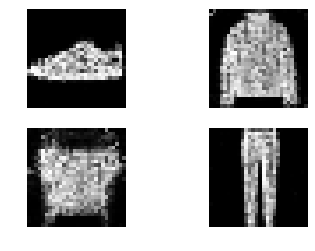

89200 [D loss: 0.636772, acc.: 60.94%] [G loss: 1.250980]


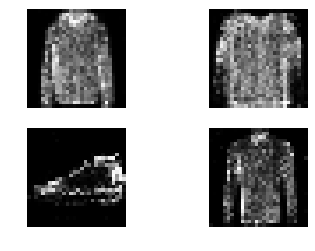

89400 [D loss: 0.591694, acc.: 70.31%] [G loss: 1.165967]


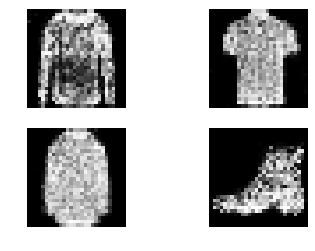

89600 [D loss: 0.625301, acc.: 68.75%] [G loss: 1.200290]


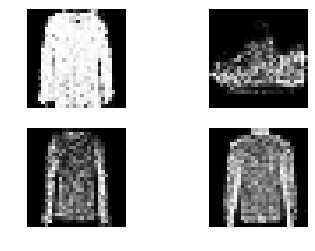

89800 [D loss: 0.606478, acc.: 62.50%] [G loss: 1.411913]


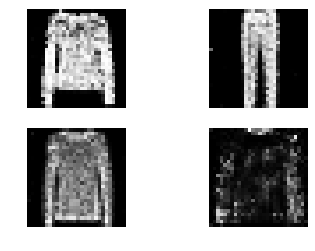

90000 [D loss: 0.613794, acc.: 71.88%] [G loss: 1.108271]


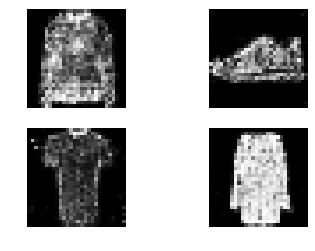

90200 [D loss: 0.579132, acc.: 70.31%] [G loss: 1.166835]


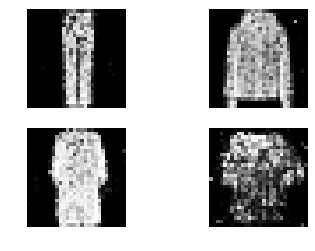

90400 [D loss: 0.601359, acc.: 64.06%] [G loss: 1.163926]


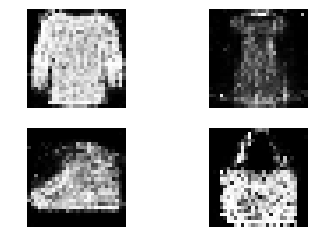

90600 [D loss: 0.635050, acc.: 59.38%] [G loss: 1.270446]


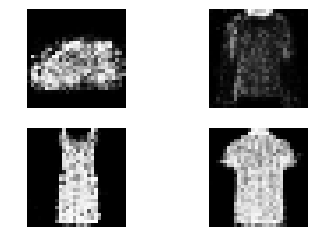

90800 [D loss: 0.633997, acc.: 64.06%] [G loss: 1.142527]


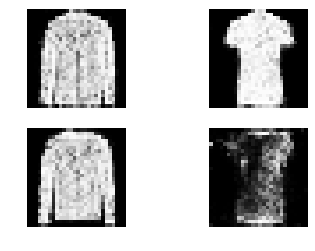

91000 [D loss: 0.545805, acc.: 76.56%] [G loss: 1.284586]


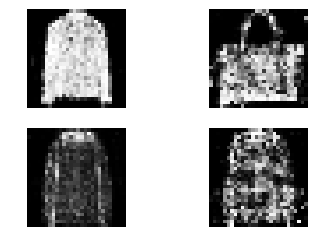

91200 [D loss: 0.534212, acc.: 76.56%] [G loss: 1.147353]


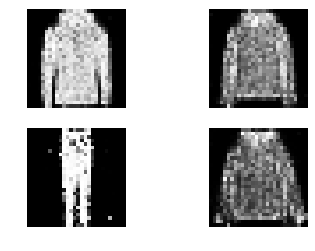

91400 [D loss: 0.559982, acc.: 78.12%] [G loss: 1.081600]


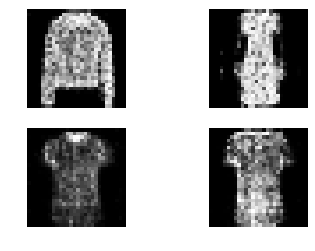

91600 [D loss: 0.679438, acc.: 65.62%] [G loss: 1.072043]


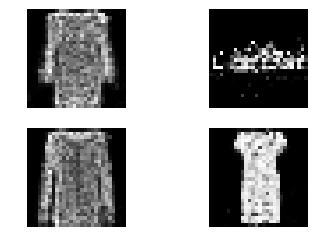

91800 [D loss: 0.513265, acc.: 76.56%] [G loss: 1.399503]


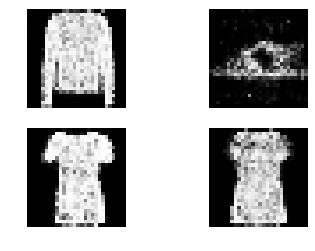

92000 [D loss: 0.567430, acc.: 70.31%] [G loss: 1.275037]


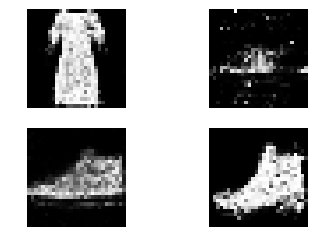

92200 [D loss: 0.526576, acc.: 73.44%] [G loss: 1.167237]


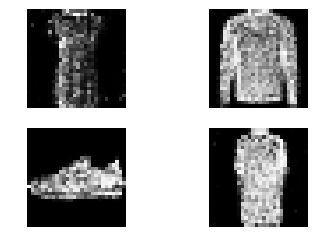

92400 [D loss: 0.574241, acc.: 73.44%] [G loss: 1.376631]


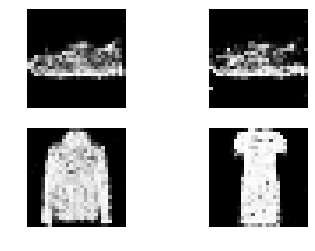

92600 [D loss: 0.558032, acc.: 70.31%] [G loss: 1.190192]


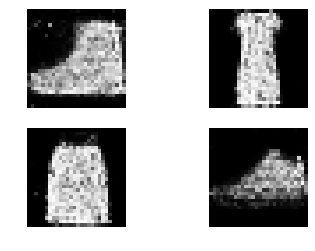

92800 [D loss: 0.548468, acc.: 78.12%] [G loss: 1.164105]


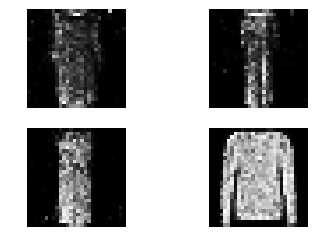

93000 [D loss: 0.565425, acc.: 75.00%] [G loss: 1.378824]


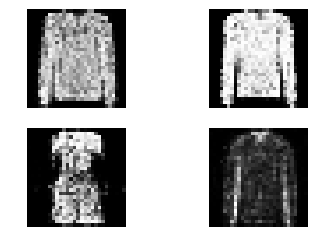

93200 [D loss: 0.455313, acc.: 79.69%] [G loss: 1.093965]


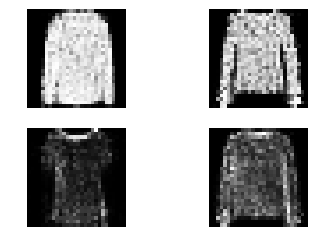

93400 [D loss: 0.565528, acc.: 73.44%] [G loss: 1.220840]


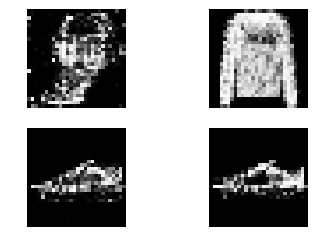

93600 [D loss: 0.494796, acc.: 79.69%] [G loss: 1.298279]


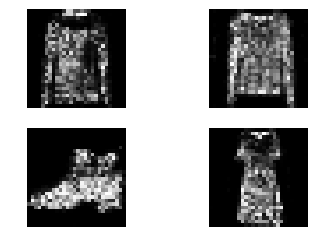

93800 [D loss: 0.572677, acc.: 64.06%] [G loss: 1.264534]


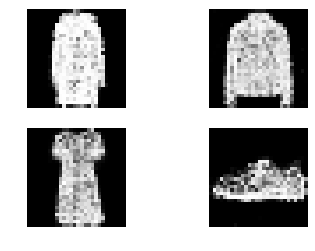

94000 [D loss: 0.564493, acc.: 64.06%] [G loss: 1.275972]


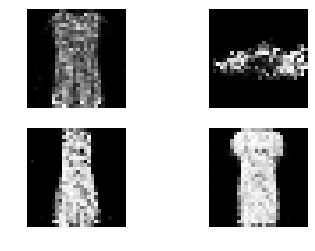

94200 [D loss: 0.502923, acc.: 70.31%] [G loss: 1.178904]


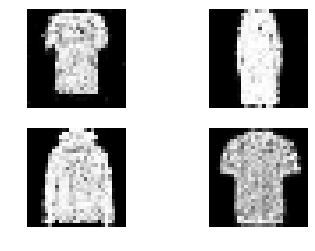

94400 [D loss: 0.589562, acc.: 78.12%] [G loss: 1.156413]


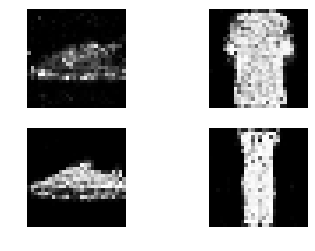

94600 [D loss: 0.555615, acc.: 70.31%] [G loss: 1.211419]


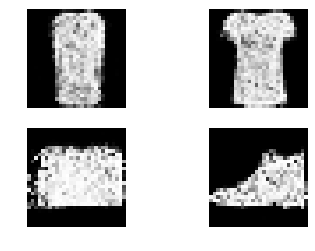

94800 [D loss: 0.515889, acc.: 75.00%] [G loss: 1.240026]


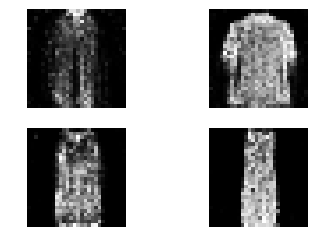

95000 [D loss: 0.544292, acc.: 70.31%] [G loss: 1.279183]


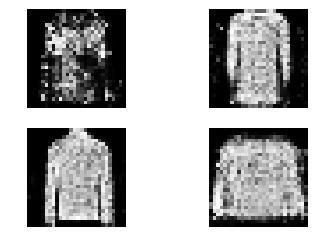

95200 [D loss: 0.651269, acc.: 60.94%] [G loss: 1.394745]


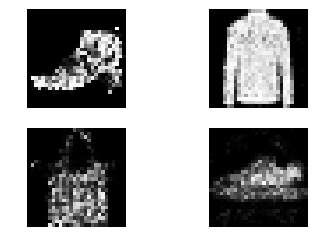

95400 [D loss: 0.540146, acc.: 76.56%] [G loss: 1.355258]


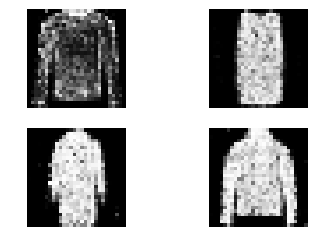

95600 [D loss: 0.589092, acc.: 59.38%] [G loss: 1.206742]


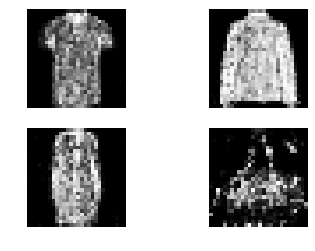

95800 [D loss: 0.571717, acc.: 64.06%] [G loss: 1.377964]


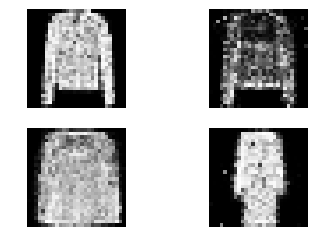

96000 [D loss: 0.610397, acc.: 71.88%] [G loss: 1.080197]


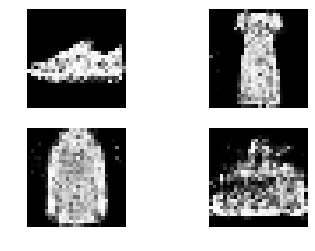

96200 [D loss: 0.587422, acc.: 67.19%] [G loss: 1.258094]


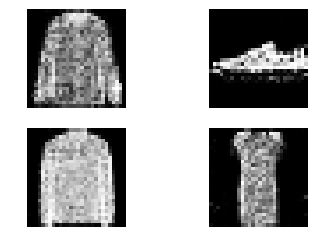

96400 [D loss: 0.565595, acc.: 62.50%] [G loss: 1.282706]


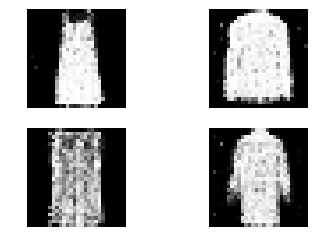

96600 [D loss: 0.552319, acc.: 67.19%] [G loss: 1.141278]


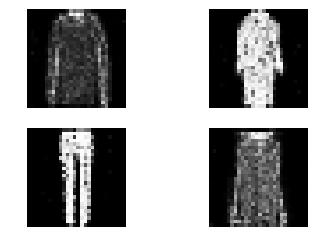

96800 [D loss: 0.575837, acc.: 67.19%] [G loss: 1.104240]


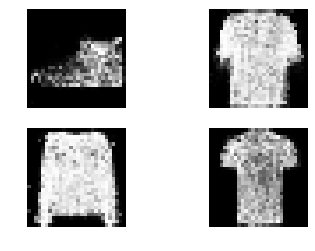

97000 [D loss: 0.618737, acc.: 68.75%] [G loss: 1.158688]


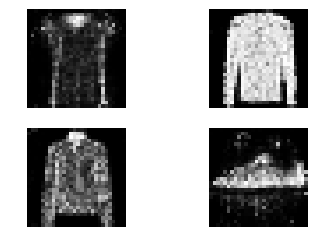

97200 [D loss: 0.458885, acc.: 79.69%] [G loss: 1.293259]


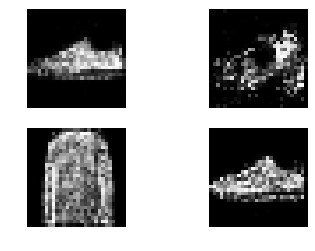

97400 [D loss: 0.508356, acc.: 76.56%] [G loss: 1.237259]


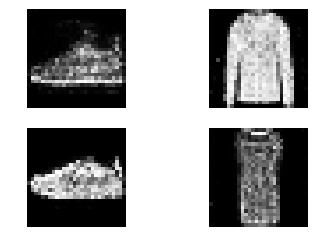

97600 [D loss: 0.589426, acc.: 75.00%] [G loss: 1.237863]


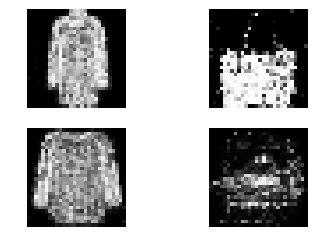

97800 [D loss: 0.632501, acc.: 64.06%] [G loss: 1.248592]


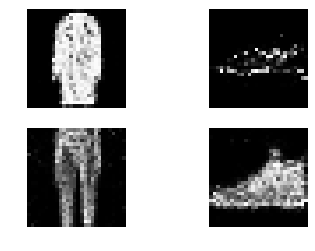

98000 [D loss: 0.508596, acc.: 75.00%] [G loss: 1.122681]


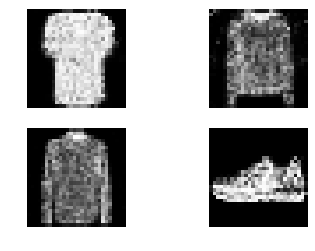

98200 [D loss: 0.548737, acc.: 75.00%] [G loss: 1.137203]


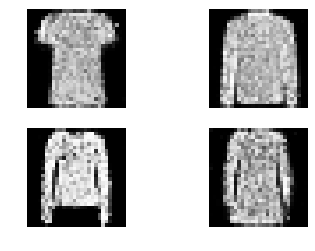

98400 [D loss: 0.671102, acc.: 60.94%] [G loss: 1.265396]


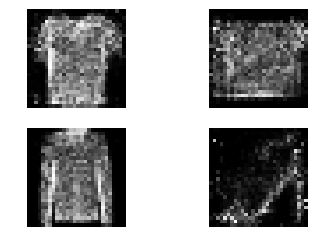

98600 [D loss: 0.466083, acc.: 82.81%] [G loss: 1.368678]


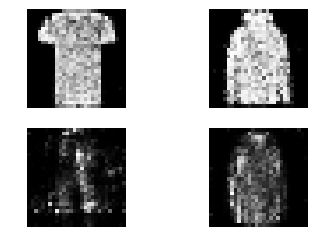

98800 [D loss: 0.560542, acc.: 73.44%] [G loss: 1.317183]


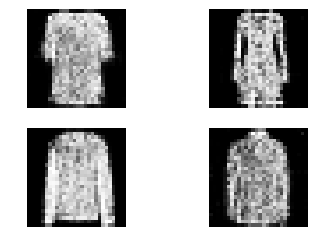

99000 [D loss: 0.487335, acc.: 79.69%] [G loss: 1.469107]


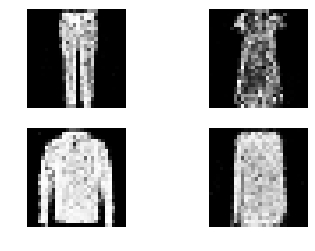

99200 [D loss: 0.535997, acc.: 68.75%] [G loss: 1.156712]


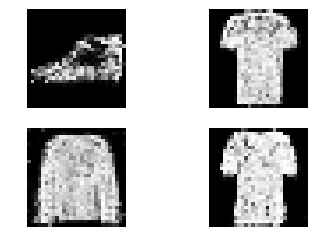

99400 [D loss: 0.660524, acc.: 65.62%] [G loss: 1.364146]


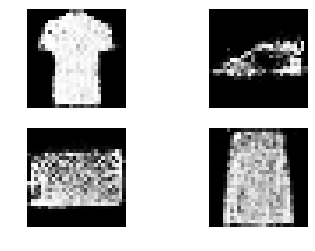

99600 [D loss: 0.500901, acc.: 78.12%] [G loss: 1.275784]


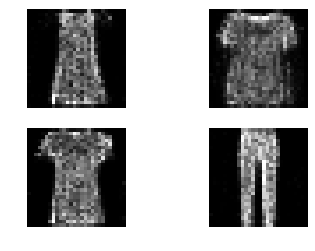

99800 [D loss: 0.514625, acc.: 76.56%] [G loss: 1.211461]


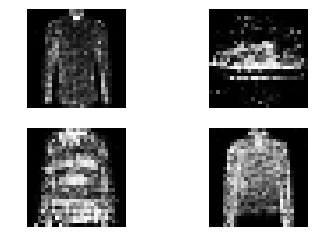

100000 [D loss: 0.710836, acc.: 62.50%] [G loss: 1.327788]


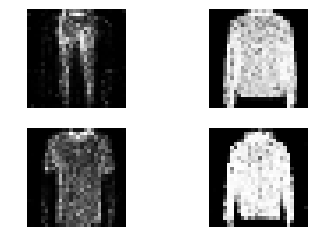

In [0]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=100001, batch_size=32, sample_interval=200)

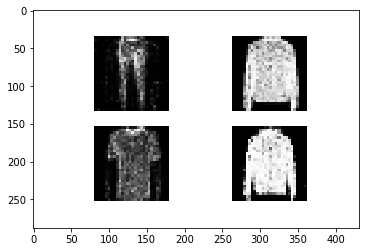

In [0]:
img = mpimg.imread('images/100000.png')
plt.imshow(img, cmap='gray')
plt.show()